In [36]:
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [38]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy


# Models


## Attention Layer


In [39]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNN


In [40]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## RNN With Attention then Expansion


In [41]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)
        print(attn_out.shape)
        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        print(expanded_attn_out.shape)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [42]:
model = NetRNNWithAttention()
print(model)
print(model(torch.Tensor(np.random.random((1,30,3)))))

NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (expand_layer): Linear(in_features=3, out_features=12, bias=True)
  (rnnLayer): RNN(12, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)
torch.Size([1, 30, 3])
torch.Size([1, 30, 12])
tensor([-0.0869, -0.2188, -0.1119], grad_fn=<SqueezeBackward0>)


## RNN Expansion first then Attention


In [43]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


## LSTM


In [44]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


## LSTM with Attention then Expansion


In [45]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


## LSTM Expansion first then Attention


In [46]:
class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


## GRU


In [47]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


## GRU with Attention then Expansion


In [48]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


## GRU Expansion first then Attention


In [49]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


# Data Generation


In [50]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [14]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,5])
print(sequences)
print(labels)

[array([[-1,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [ 0,  0, -1],
       [ 0,  0, -1]])]
[[-1  1  1]]


In [15]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

tensor([[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 1.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0., -1.],
         [ 0.,  0., -1.]]])
torch.Size([1, 3])
NetRNN(
  (expand_layer): Linear(in_features=3, out_features=12, bias=True)
  (rnnLayer): RNN(12, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_30994/996492457.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  output=model(torch.Tensor(sequences))


/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_30994/667699806.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


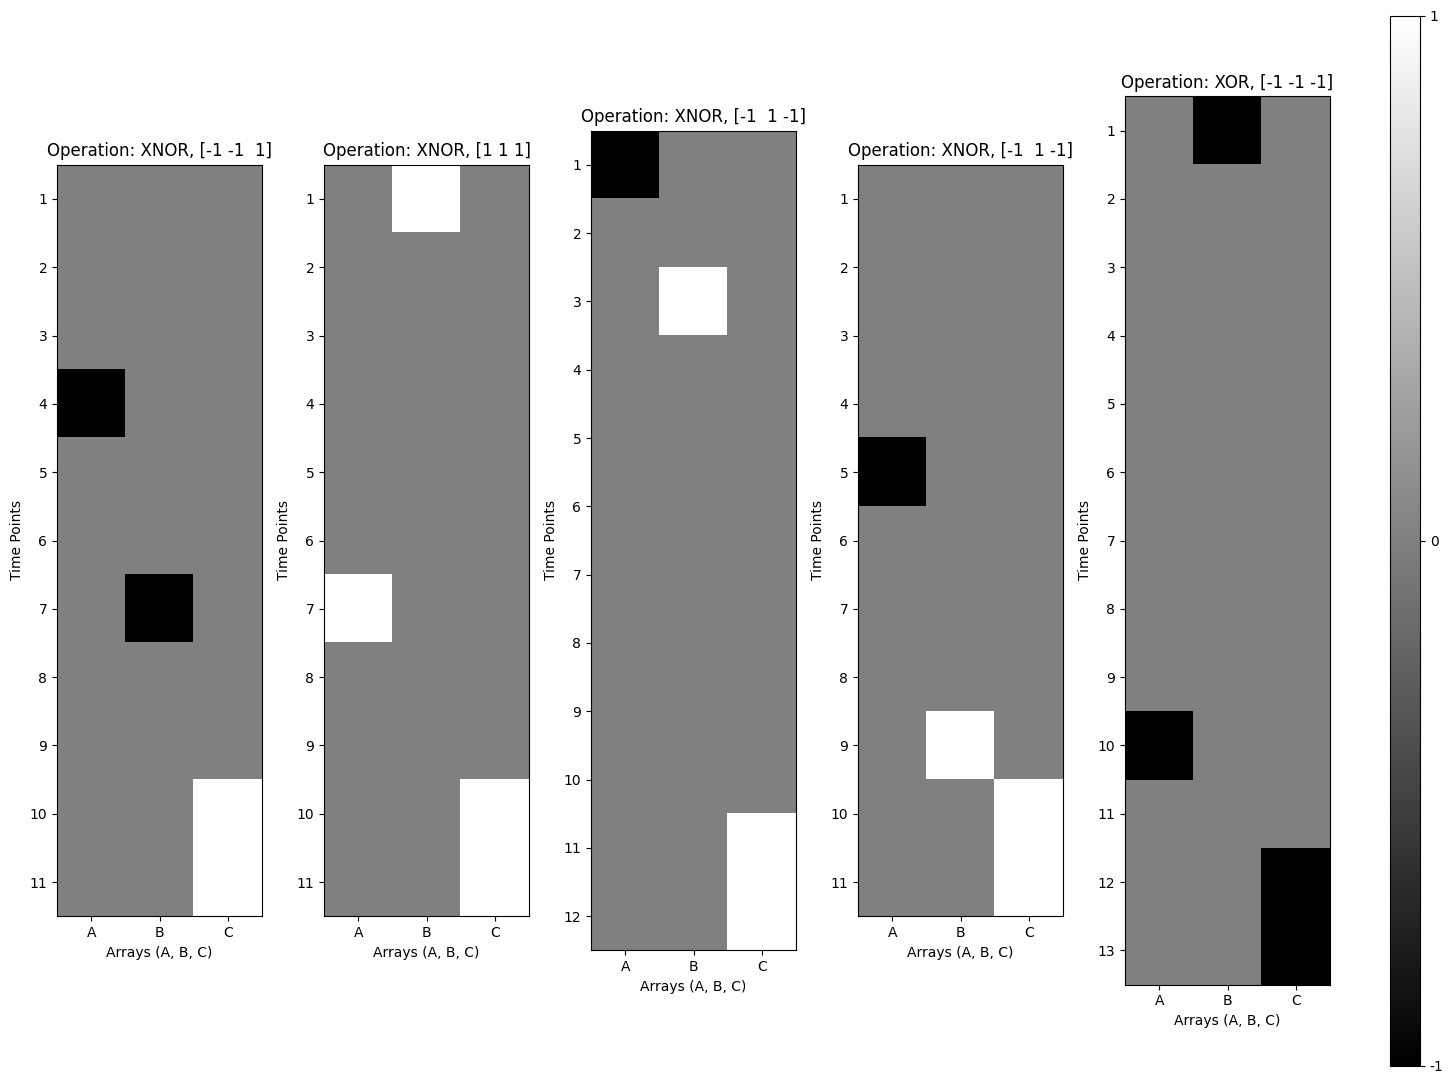

In [16]:

sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [17]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [10]
max_lengths = [10]

# Training


In [ ]:
collectorA = dict()
num_samples = 100
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        for kind in ["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME", "GRU", "GRUA","GRUE"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

                end_time = time.time()  # End time of the epoch
                epoch_duration = end_time - start_time  # Calculate duration
                collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
                torch.save(model, f'model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model')
                print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
                df=pd.DataFrame()
                df["accuracy"]=AC
                df["loss"]=W
                df.to_csv(f'score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

In [ ]:
print(collectorA.keys())

dict_keys(['RNN_rep_0_min_5 max_5', 'RNNA_rep_0_min_5 max_5', 'RNNE_rep_0_min_5 max_5', 'LSTM_rep_0_min_5 max_5', 'LSTMA_rep_0_min_5 max_5', 'LSTME_rep_0_min_5 max_5', 'GRU_rep_0_min_5 max_5', 'GRUA_rep_0_min_5 max_5', 'GRUE_rep_0_min_5 max_5'])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Ws = dict()
kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]

plt.figure(figsize=(18, 4))  # Adjust the figure size as needed

for k, kind in enumerate(kinds):
    for min_len, max_len in zip(min_lengths, max_lengths):

        plt.subplot(1, len(kinds), k+1)  # Creating subplots
        As = []
        lengths = []

        for rep in range(1):
            A = collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"]
            As.append(A)
            lengths.append(len(A))

        # Pad sequences to have the same length
        max_length = max(lengths)
        for rep in range(1):
            As[rep].extend([As[rep][-1]] * (max_length - lengths[rep]))

        W = np.array(As)
        plt.plot(W.mean(axis=0))  # Plot the mean
        plt.title(kind)  # Set the title for each subplot

        Ws[kind] = W  # Store the results

plt.tight_layout()
plt.show()


# Accuracy plots


In [52]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        return data + [pad_value] * (target_length - len(data))

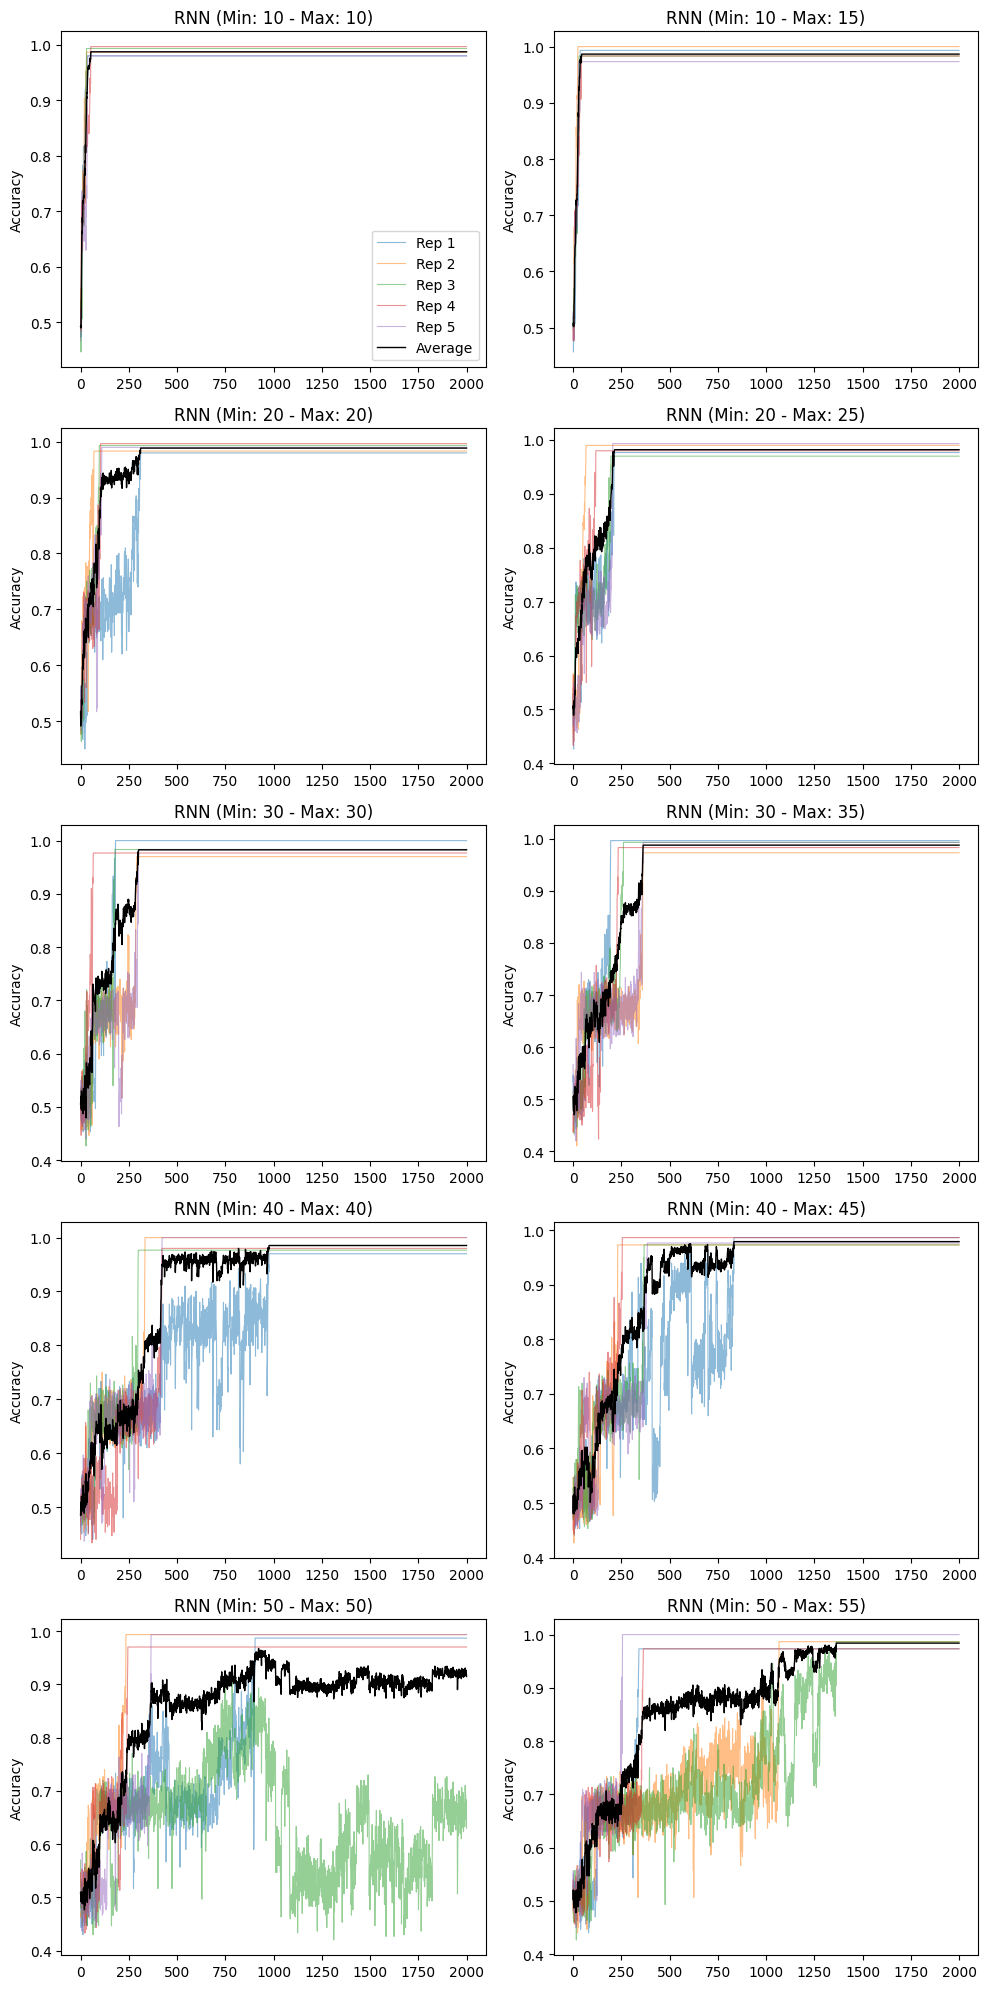

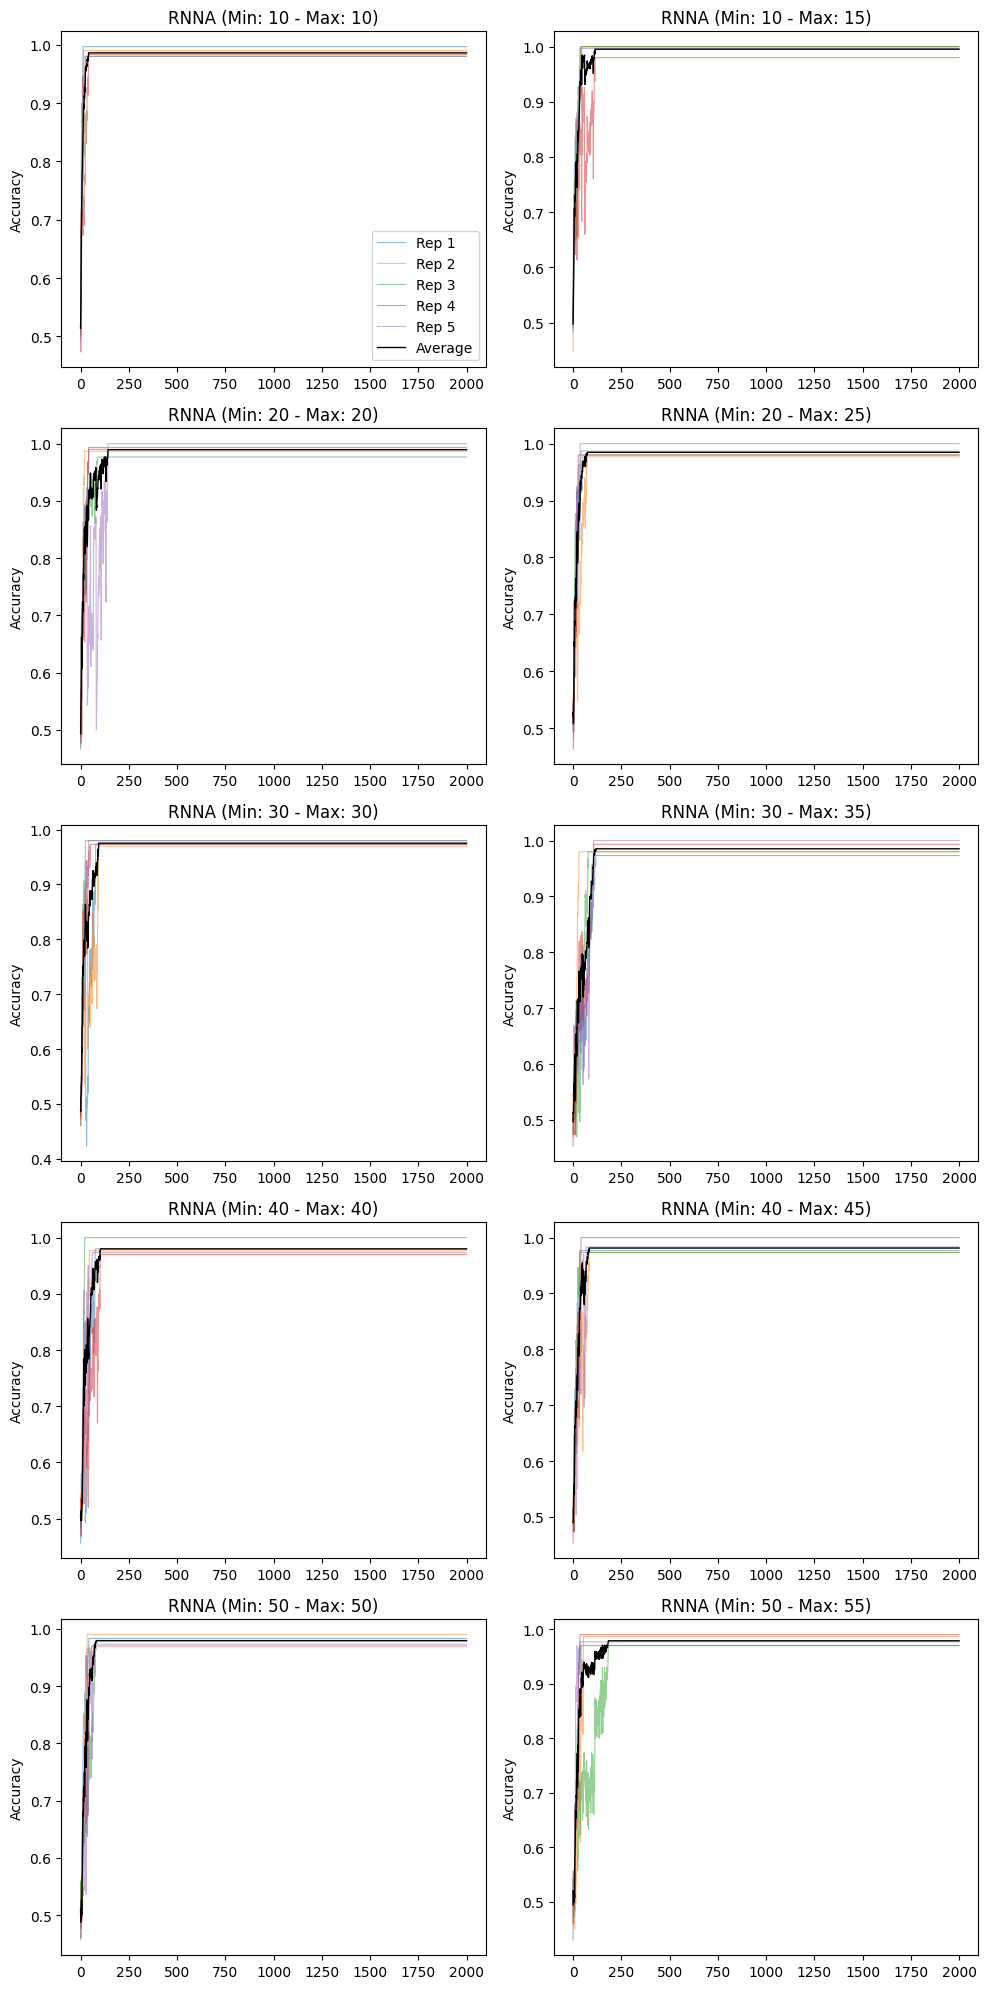

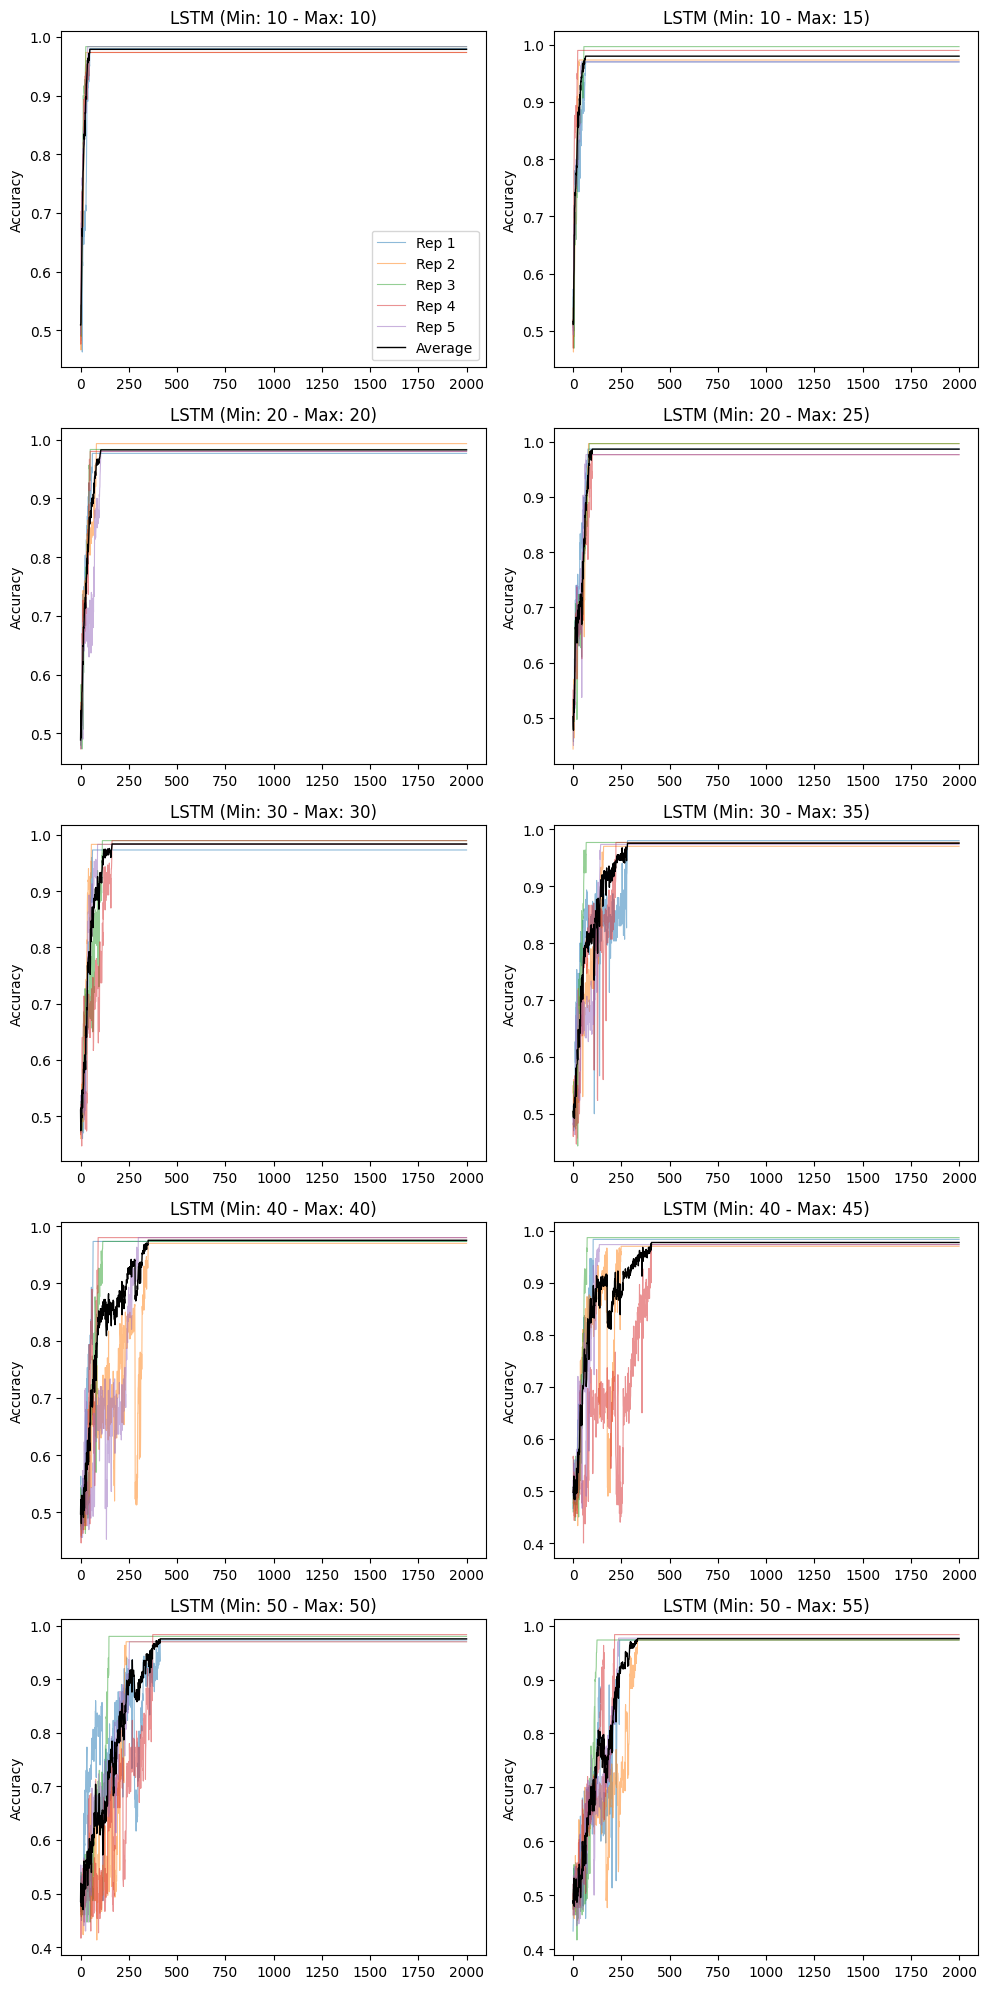

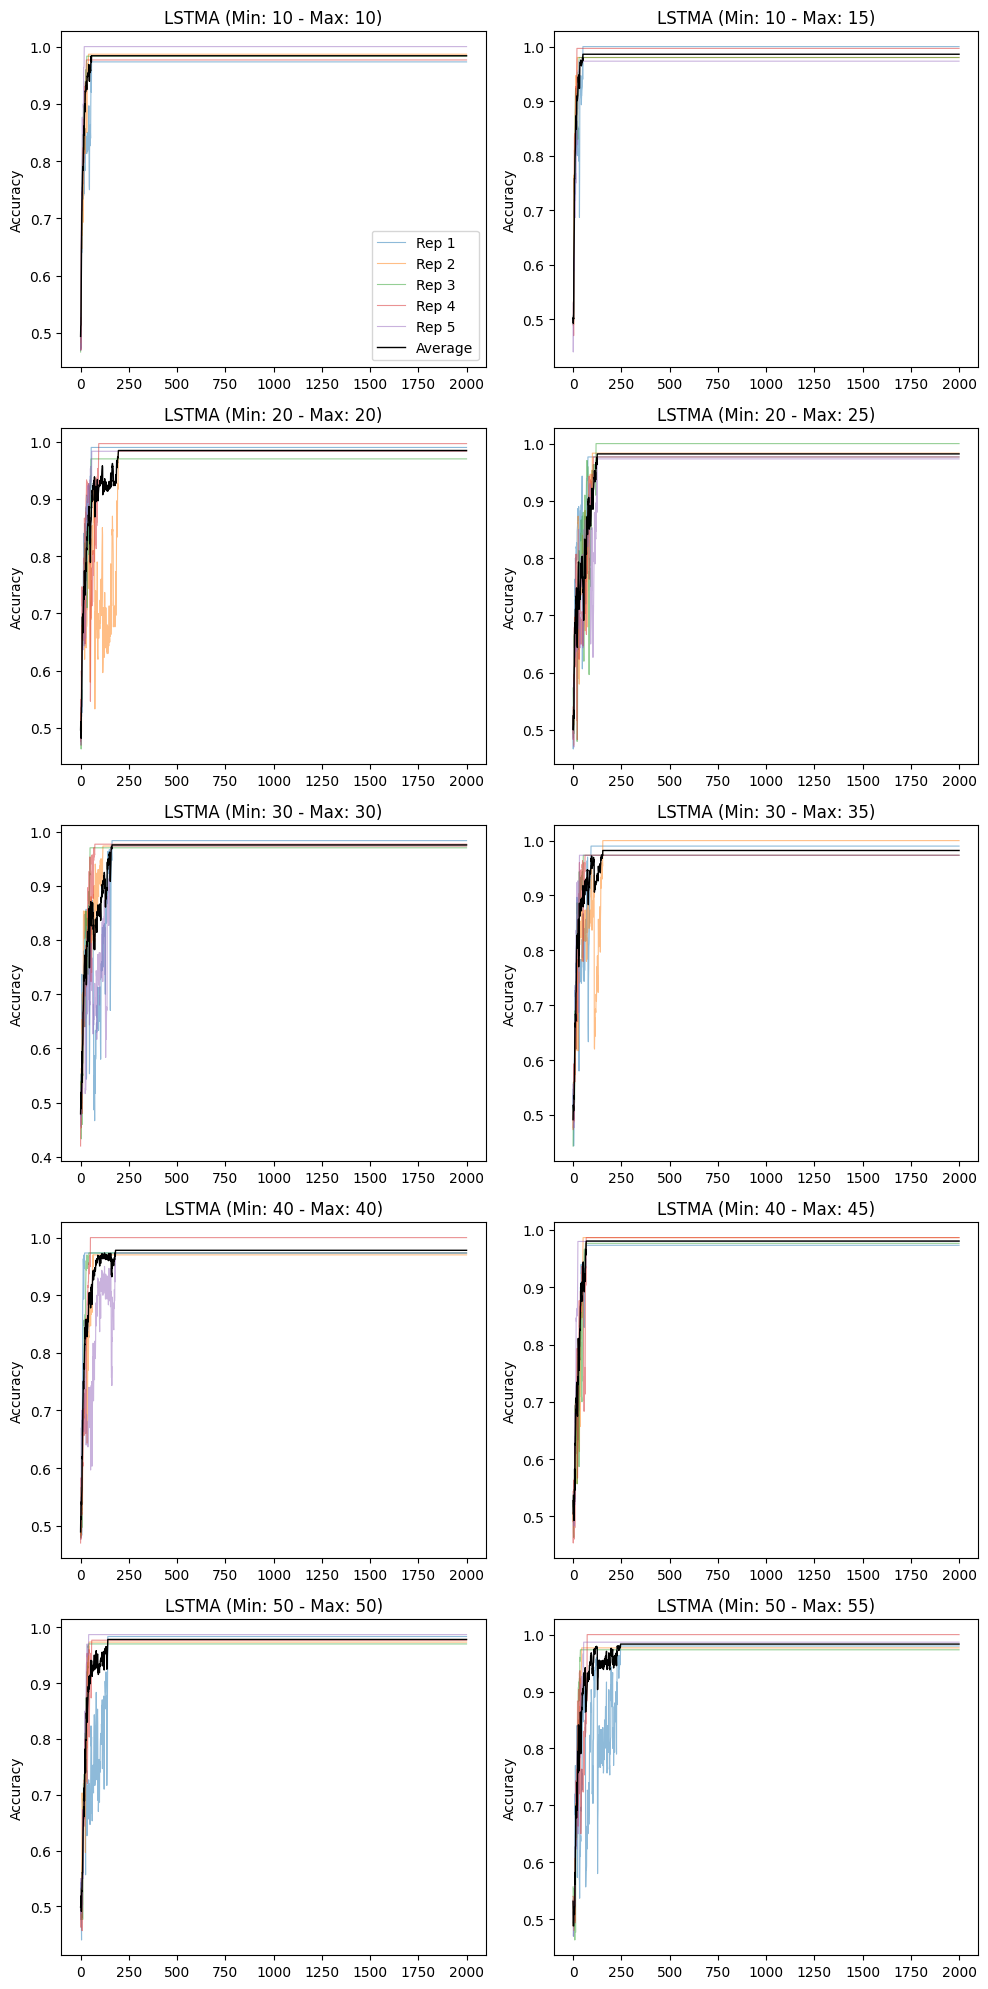

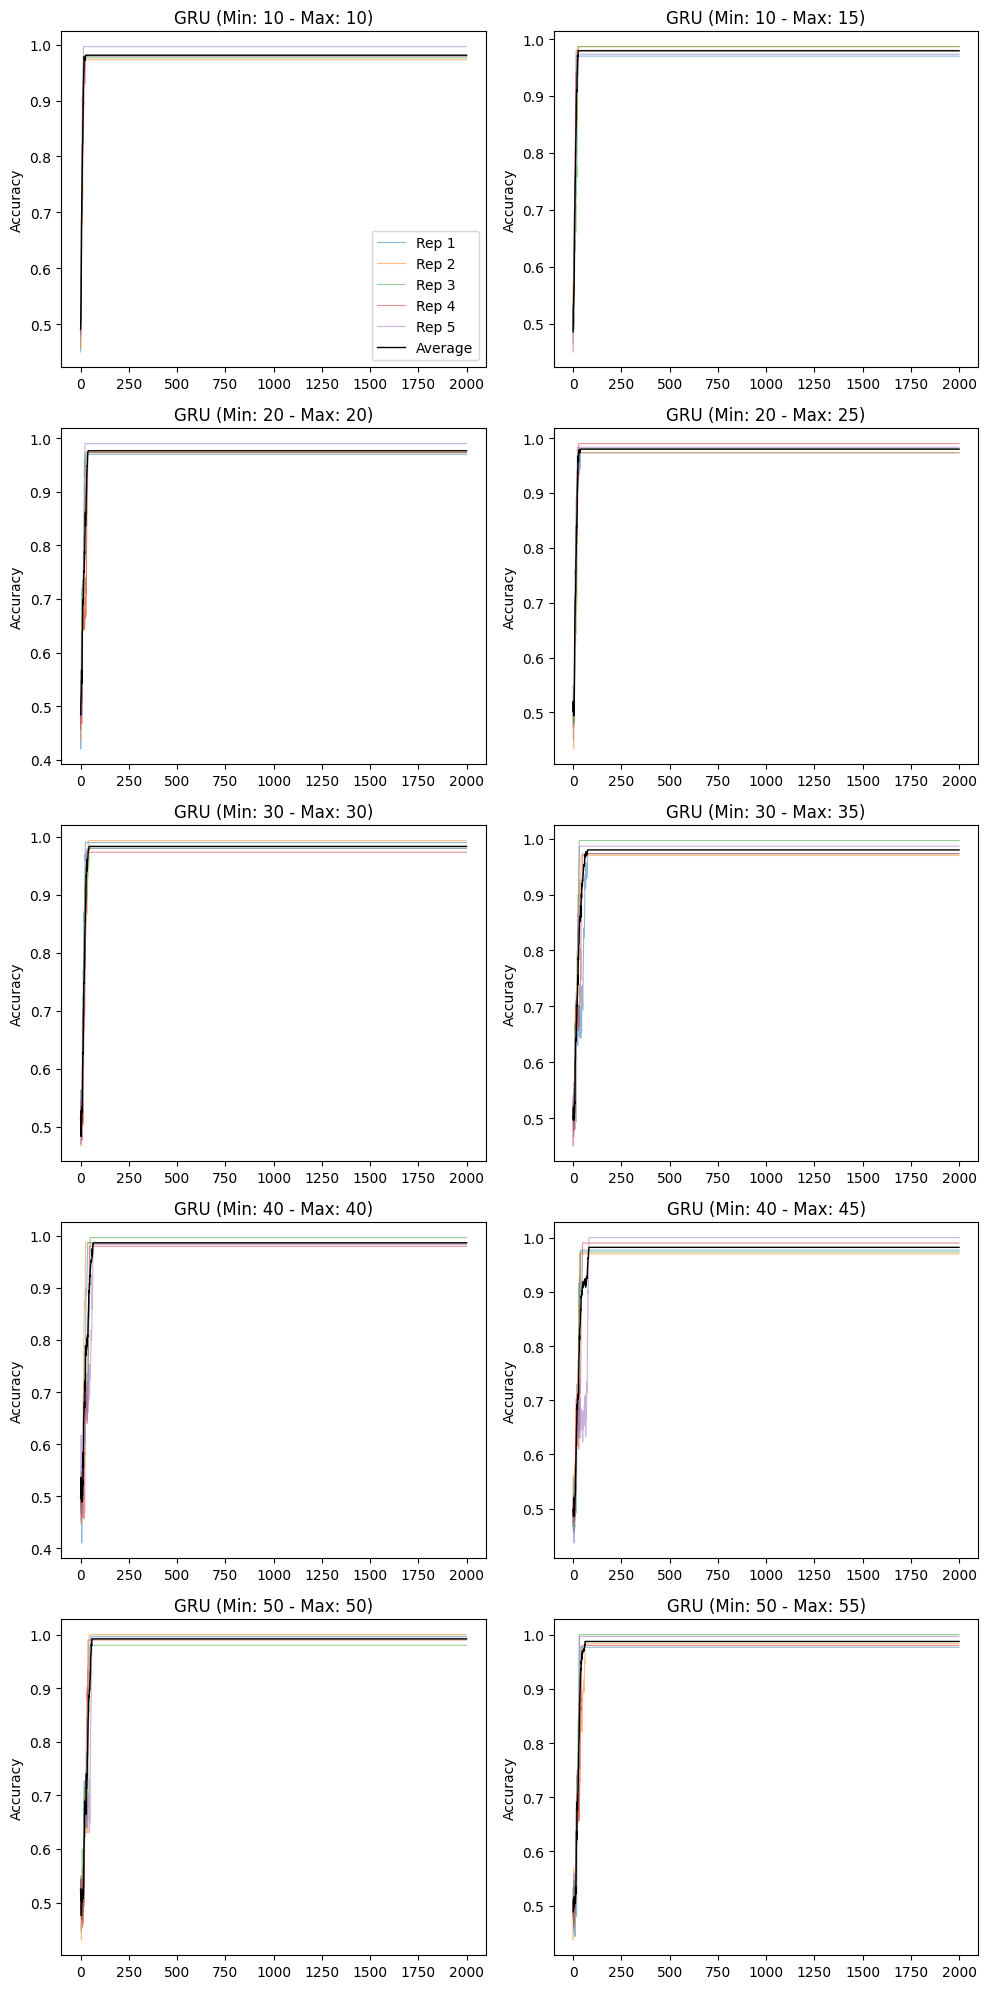

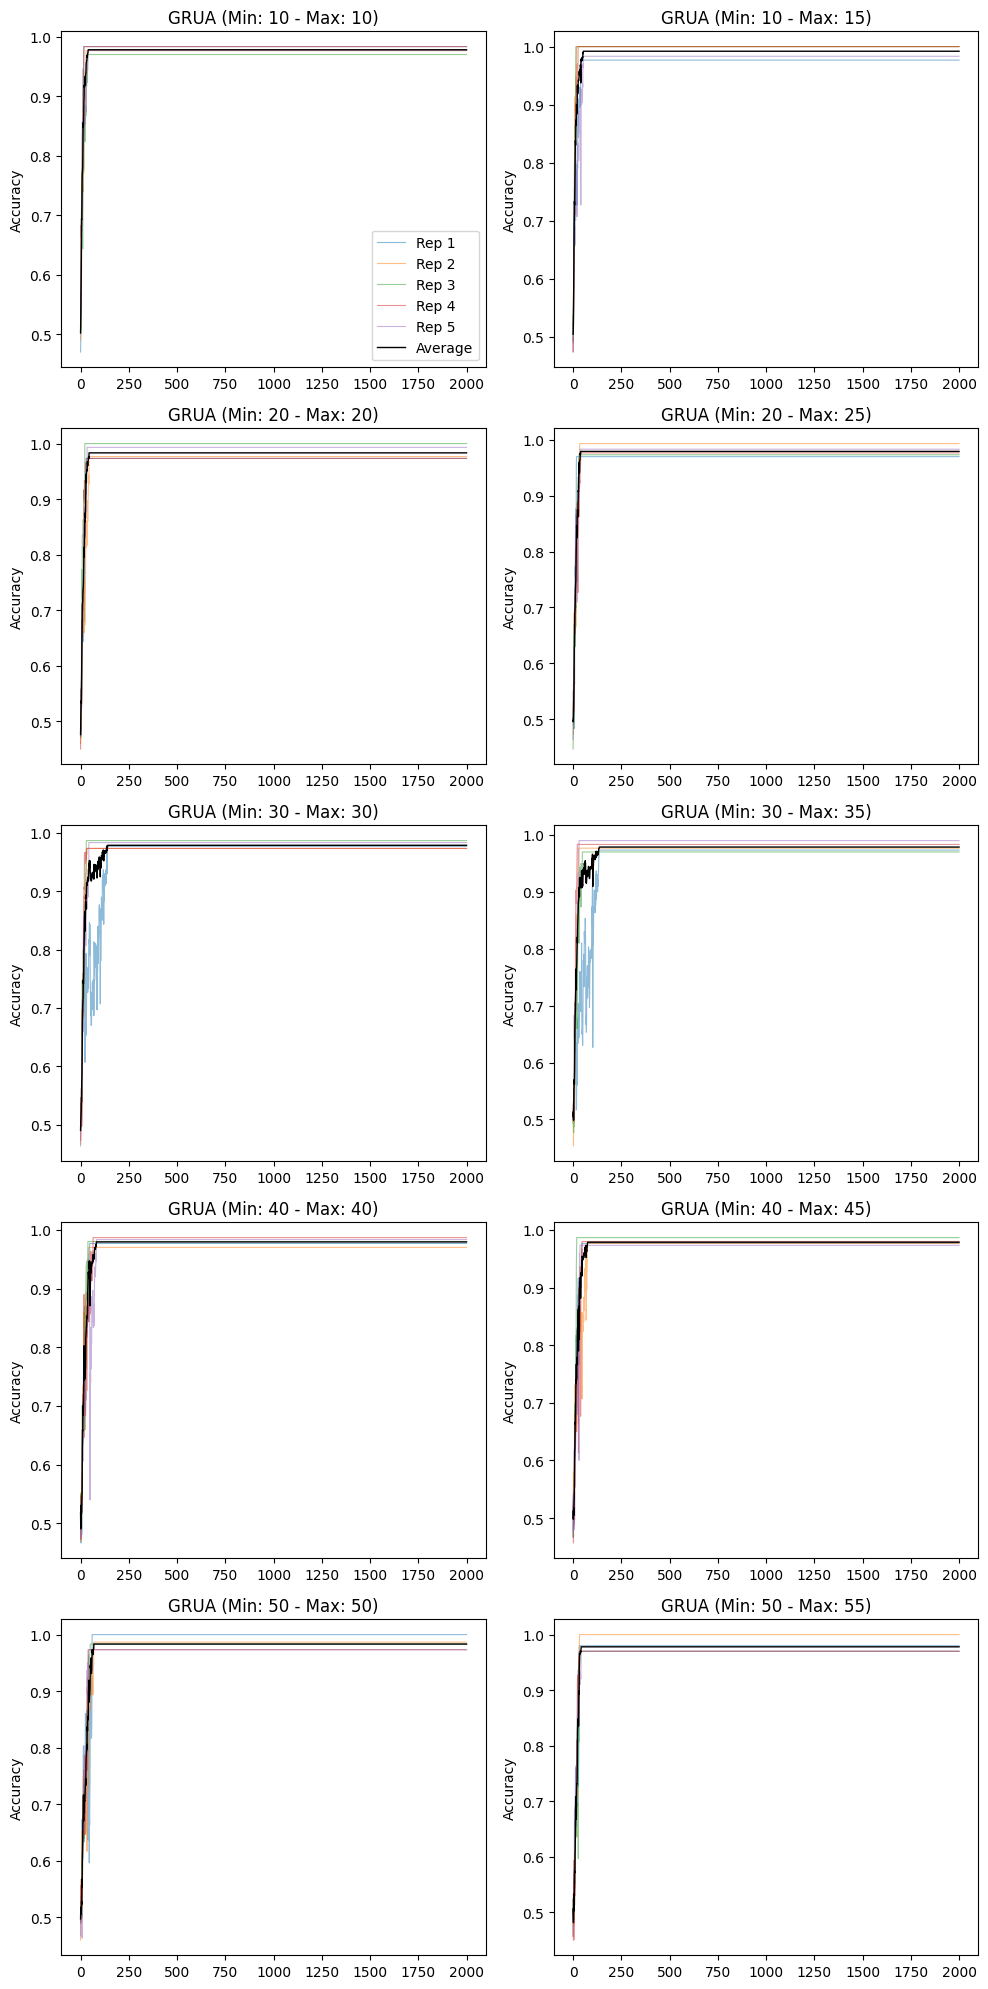

In [35]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Plotting for each kind
for kind in kinds:
    plt.figure(figsize=(10, 20))  # Adjust the figure size for 2x5 layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid
        rep_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'

            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                rep_data.append(padded_data)
                ax.plot(padded_data, label=f"Rep {rep+1}", alpha=0.5,linewidth=0.8)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if not rep_data:
            continue

        avg_data = np.mean(np.array(rep_data), axis=0)
        ax.plot(avg_data, label="Average", linewidth=1, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        #if i == 0:  # Add legend only to the first subplot
        #    ax.legend()
        ax.set_ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


    


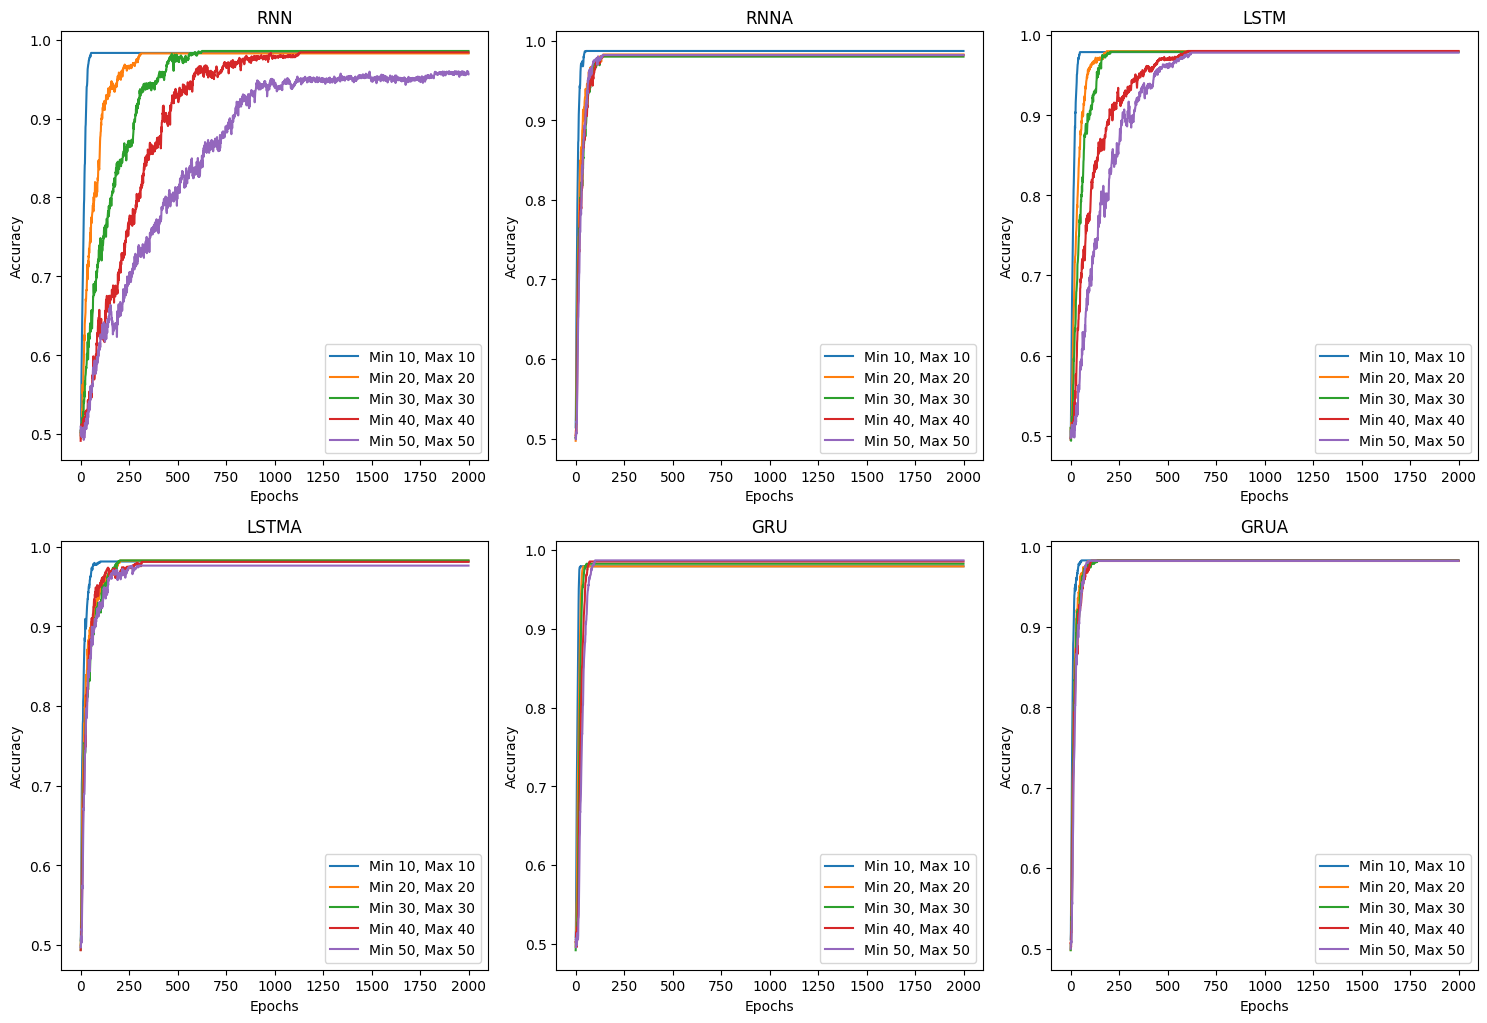

In [36]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [10, 20, 30, 40, 50]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}")

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


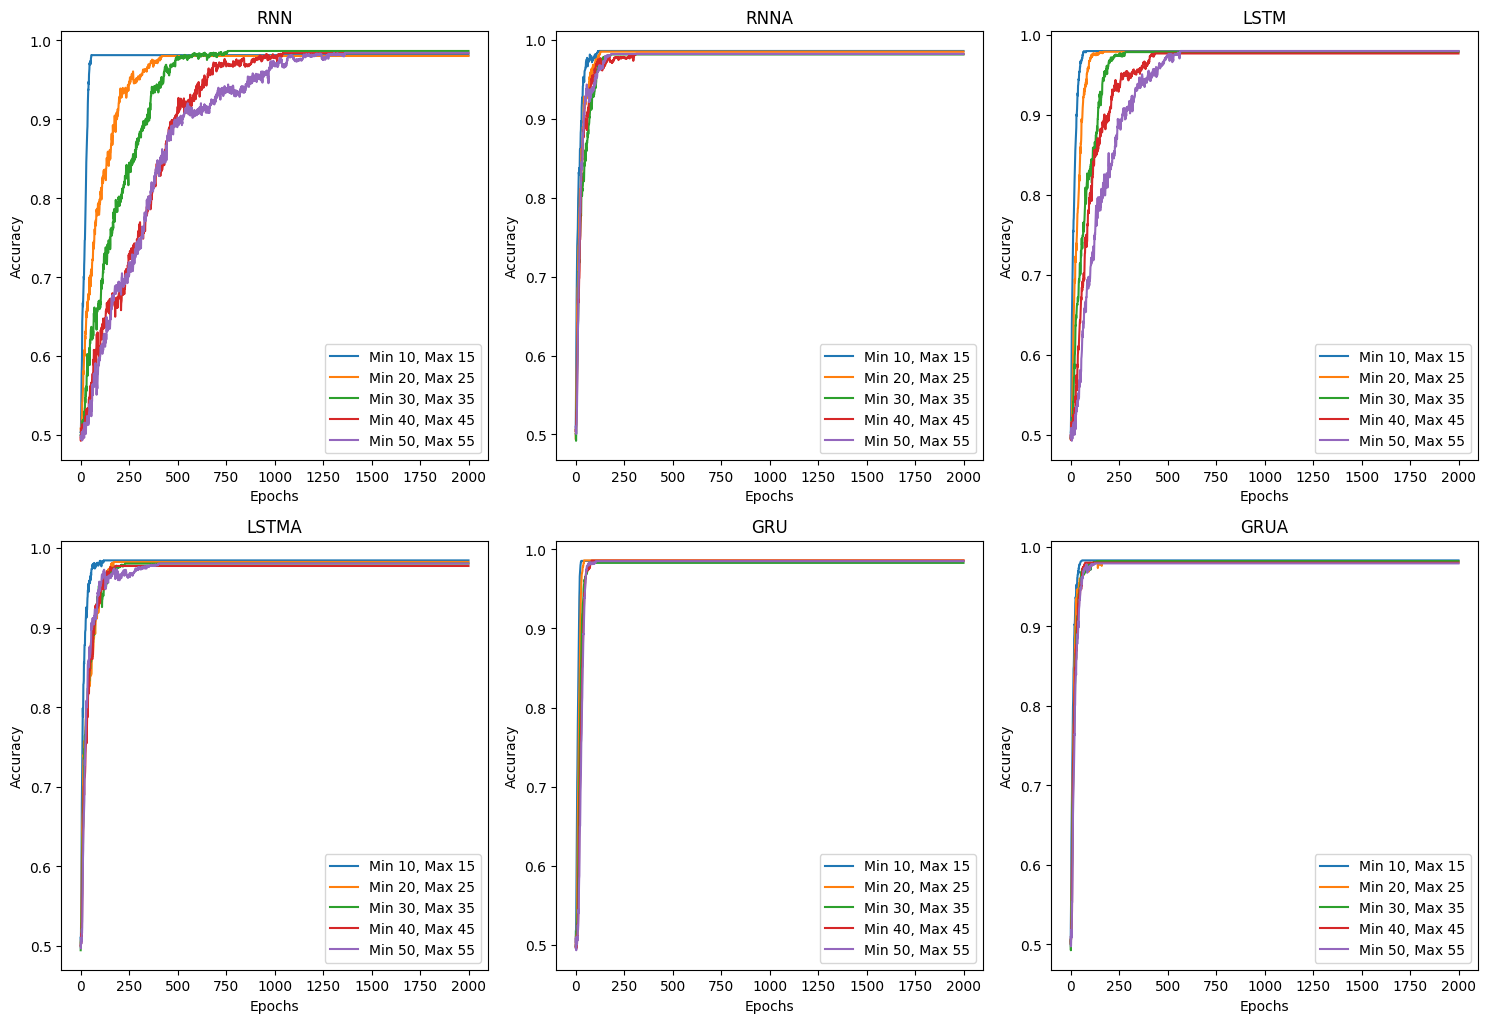

In [37]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}")

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




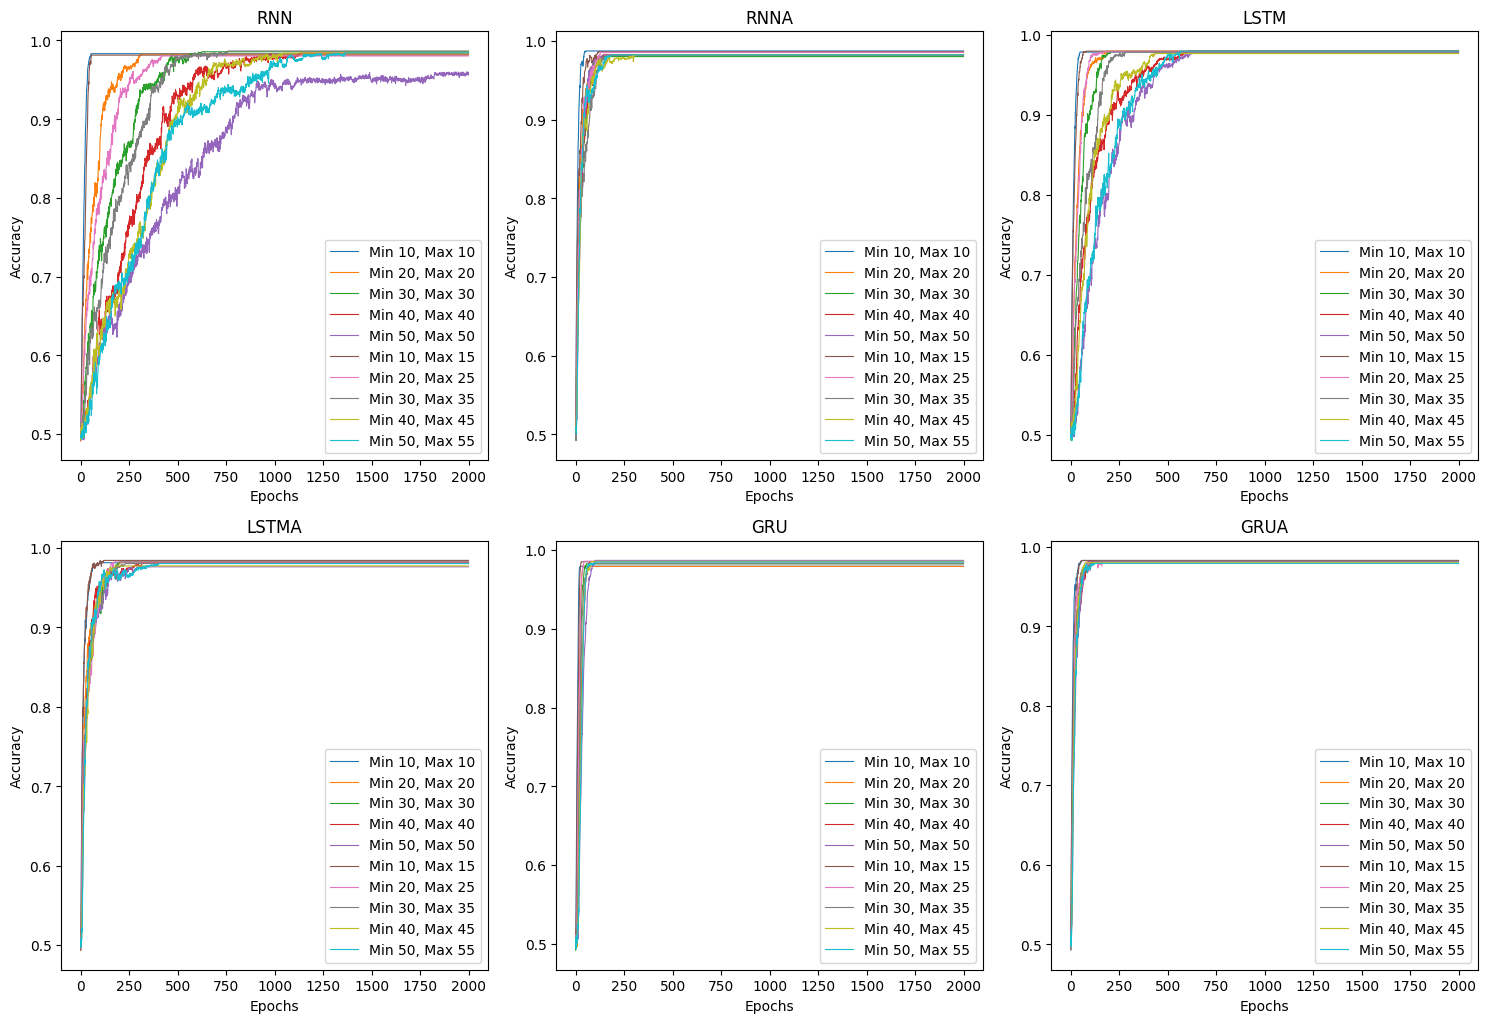

In [38]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 3, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth= 0.8)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




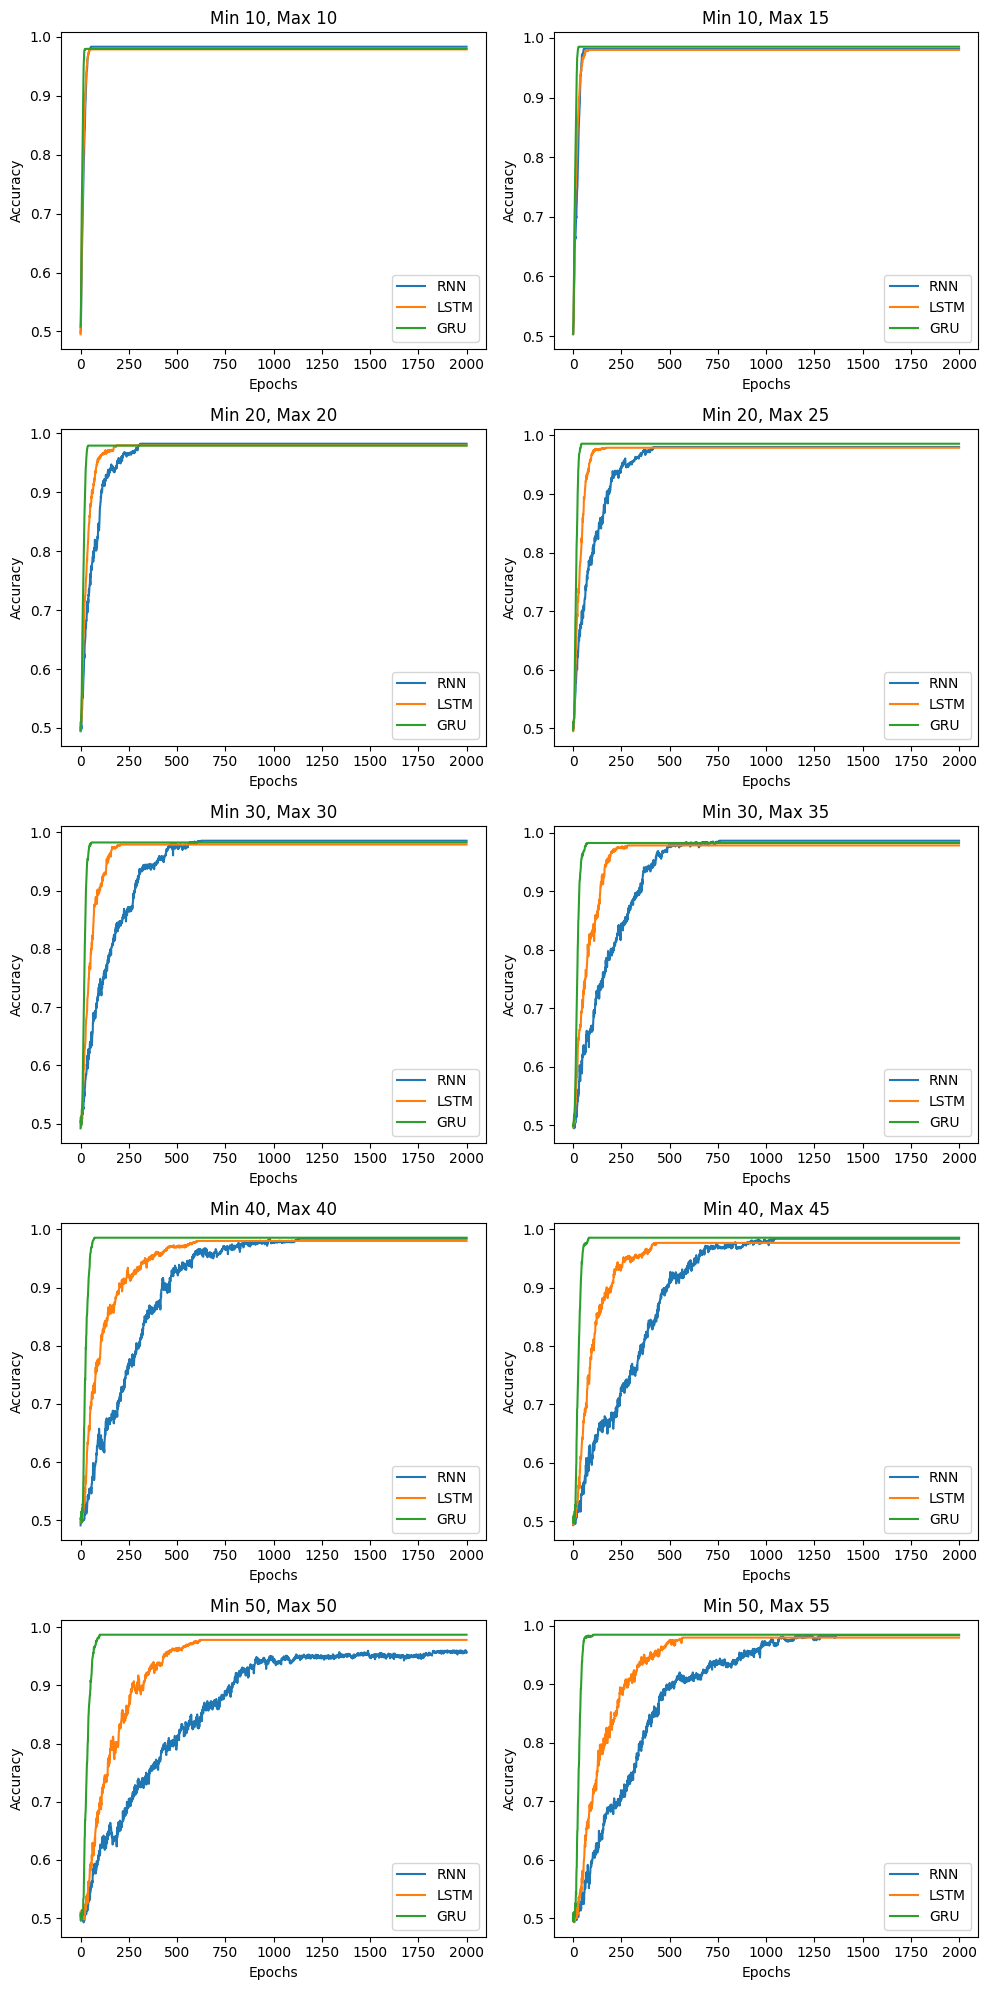

In [39]:
kinds = ["RNN", "LSTM","GRU"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


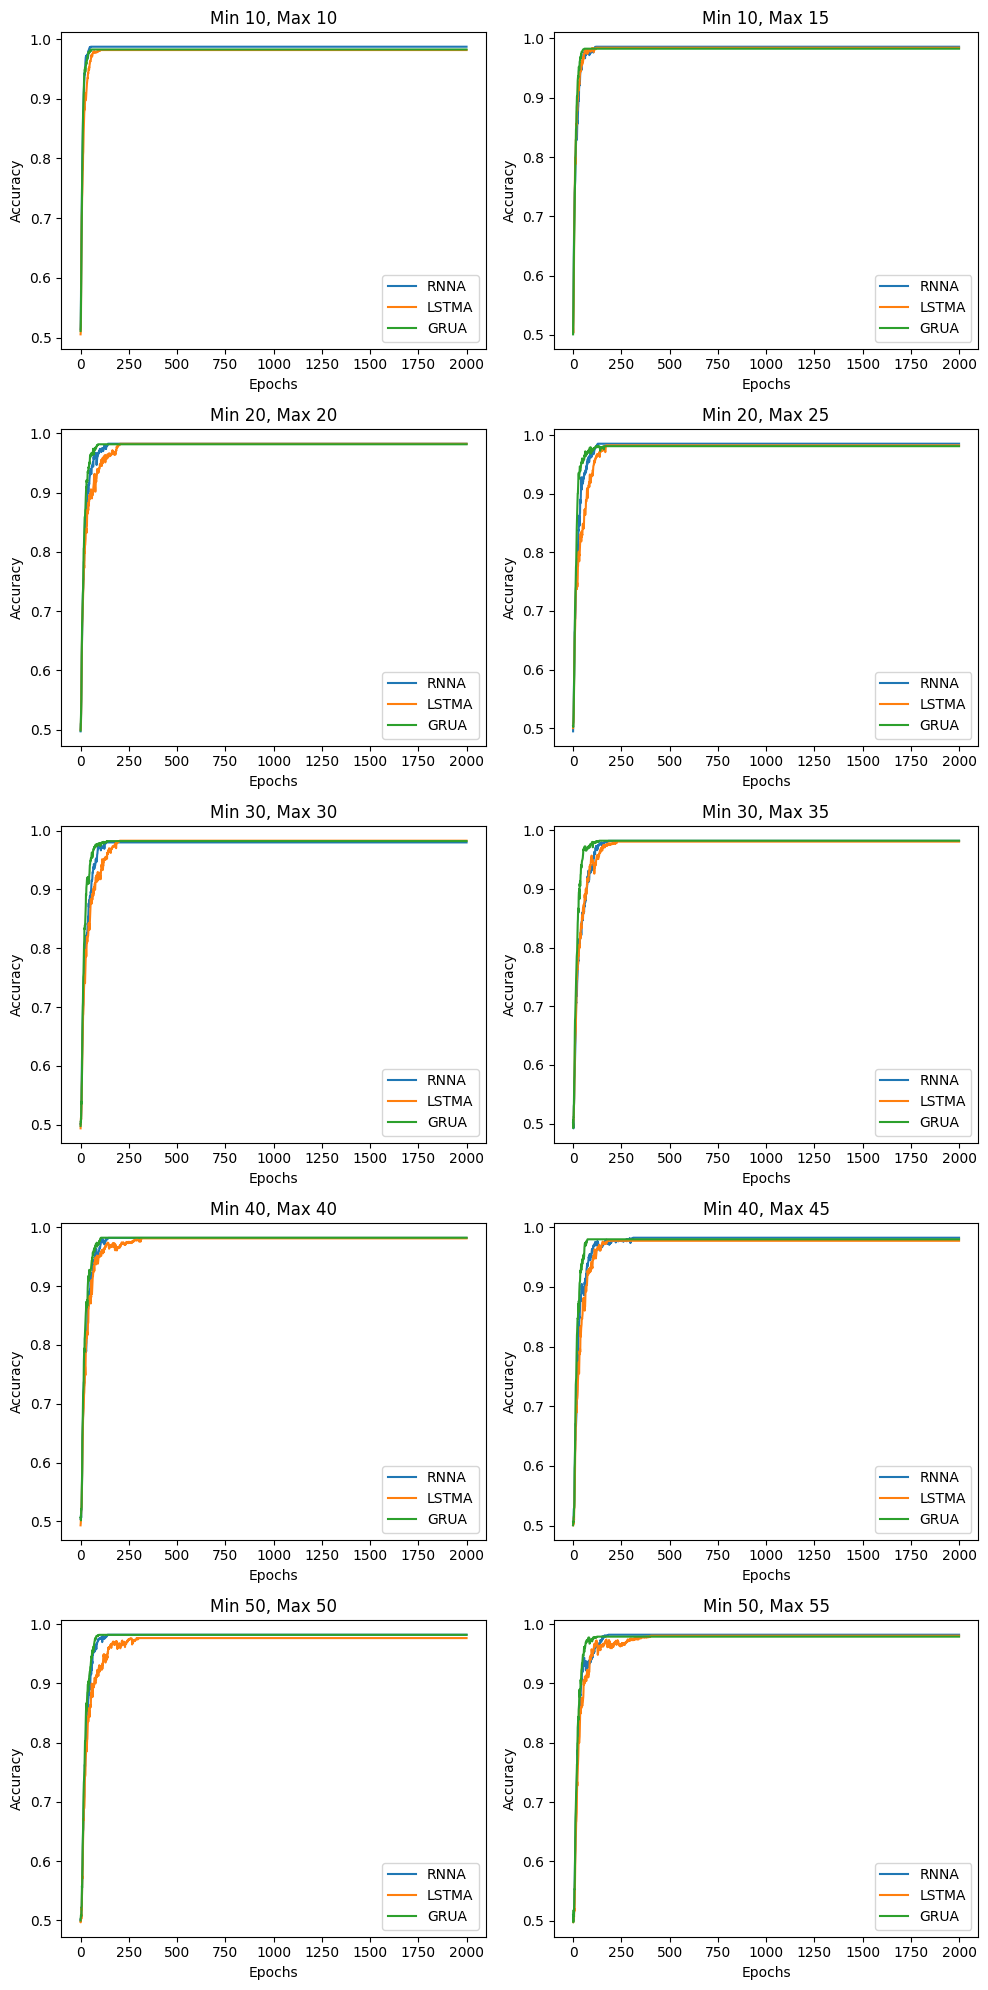

In [40]:
kinds = ["RNNA", "LSTMA",  "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
kinds = ["RNNE", "LSTME", "GRUE"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


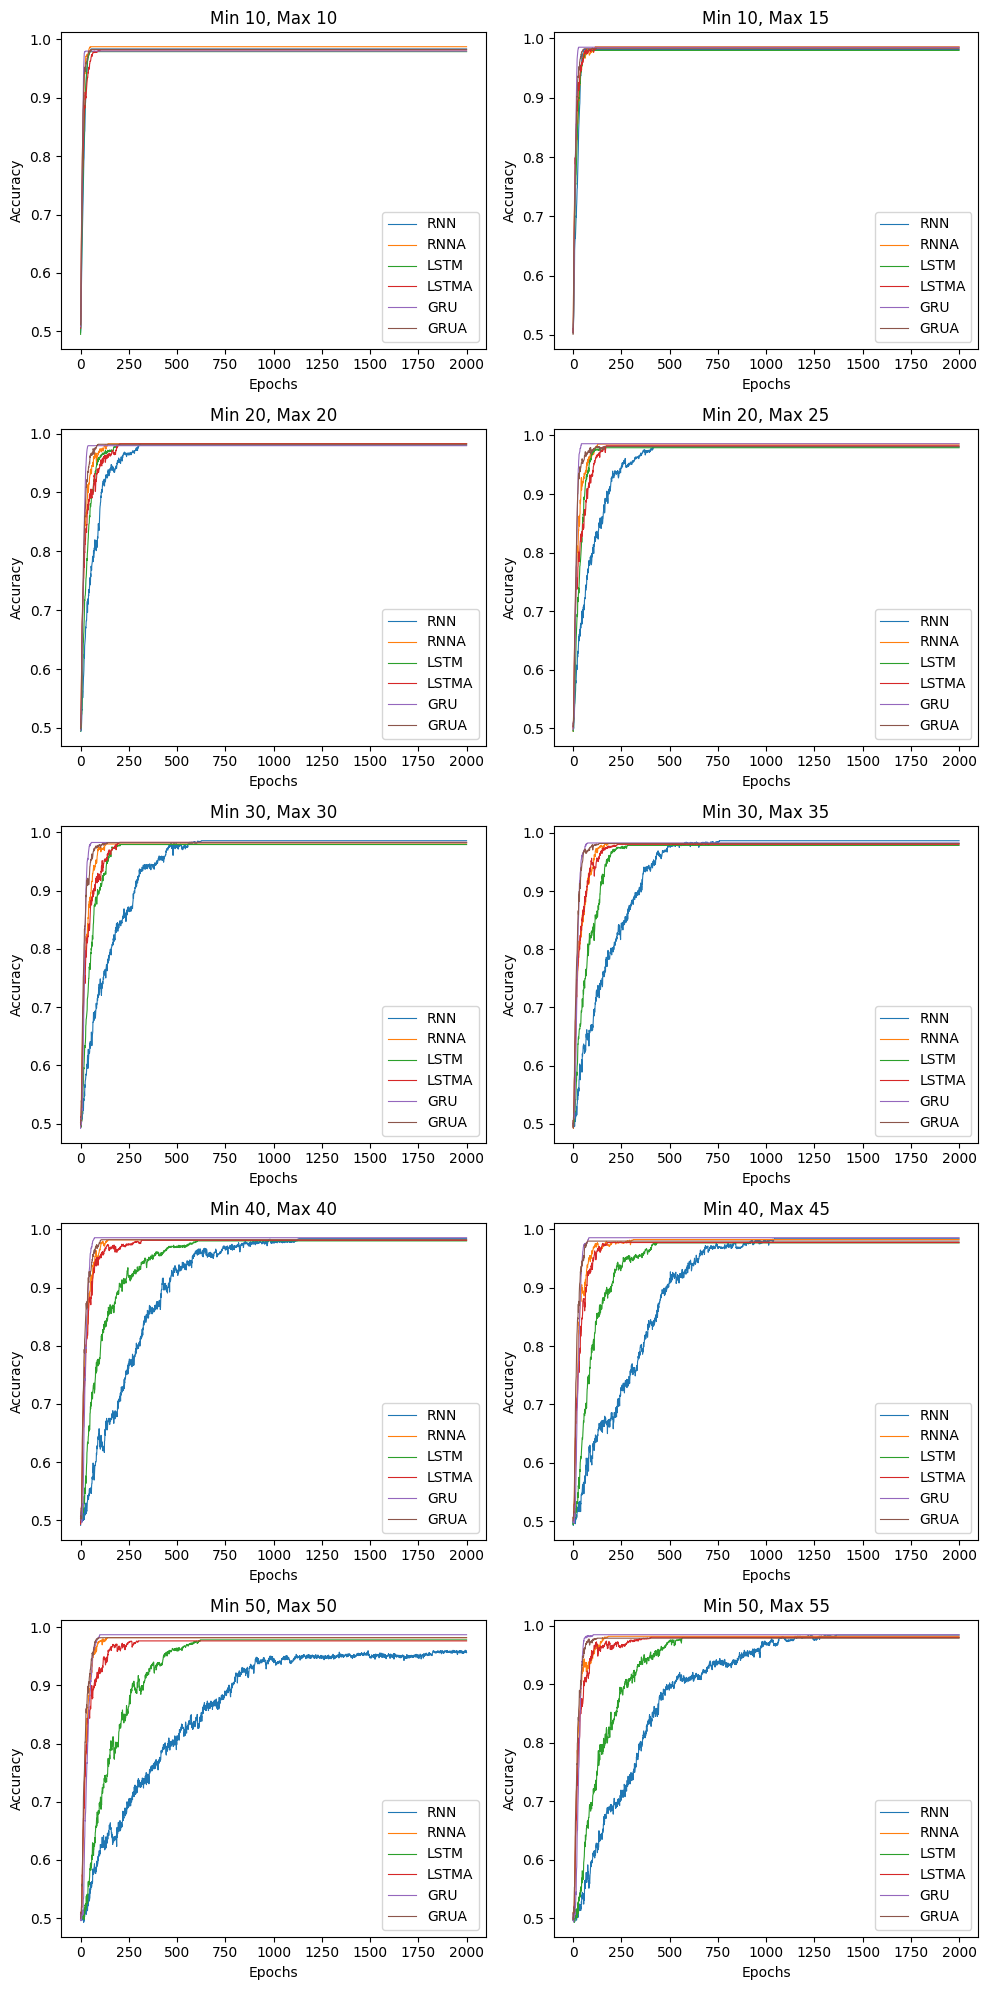

In [42]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}", linewidth= 0.8)

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


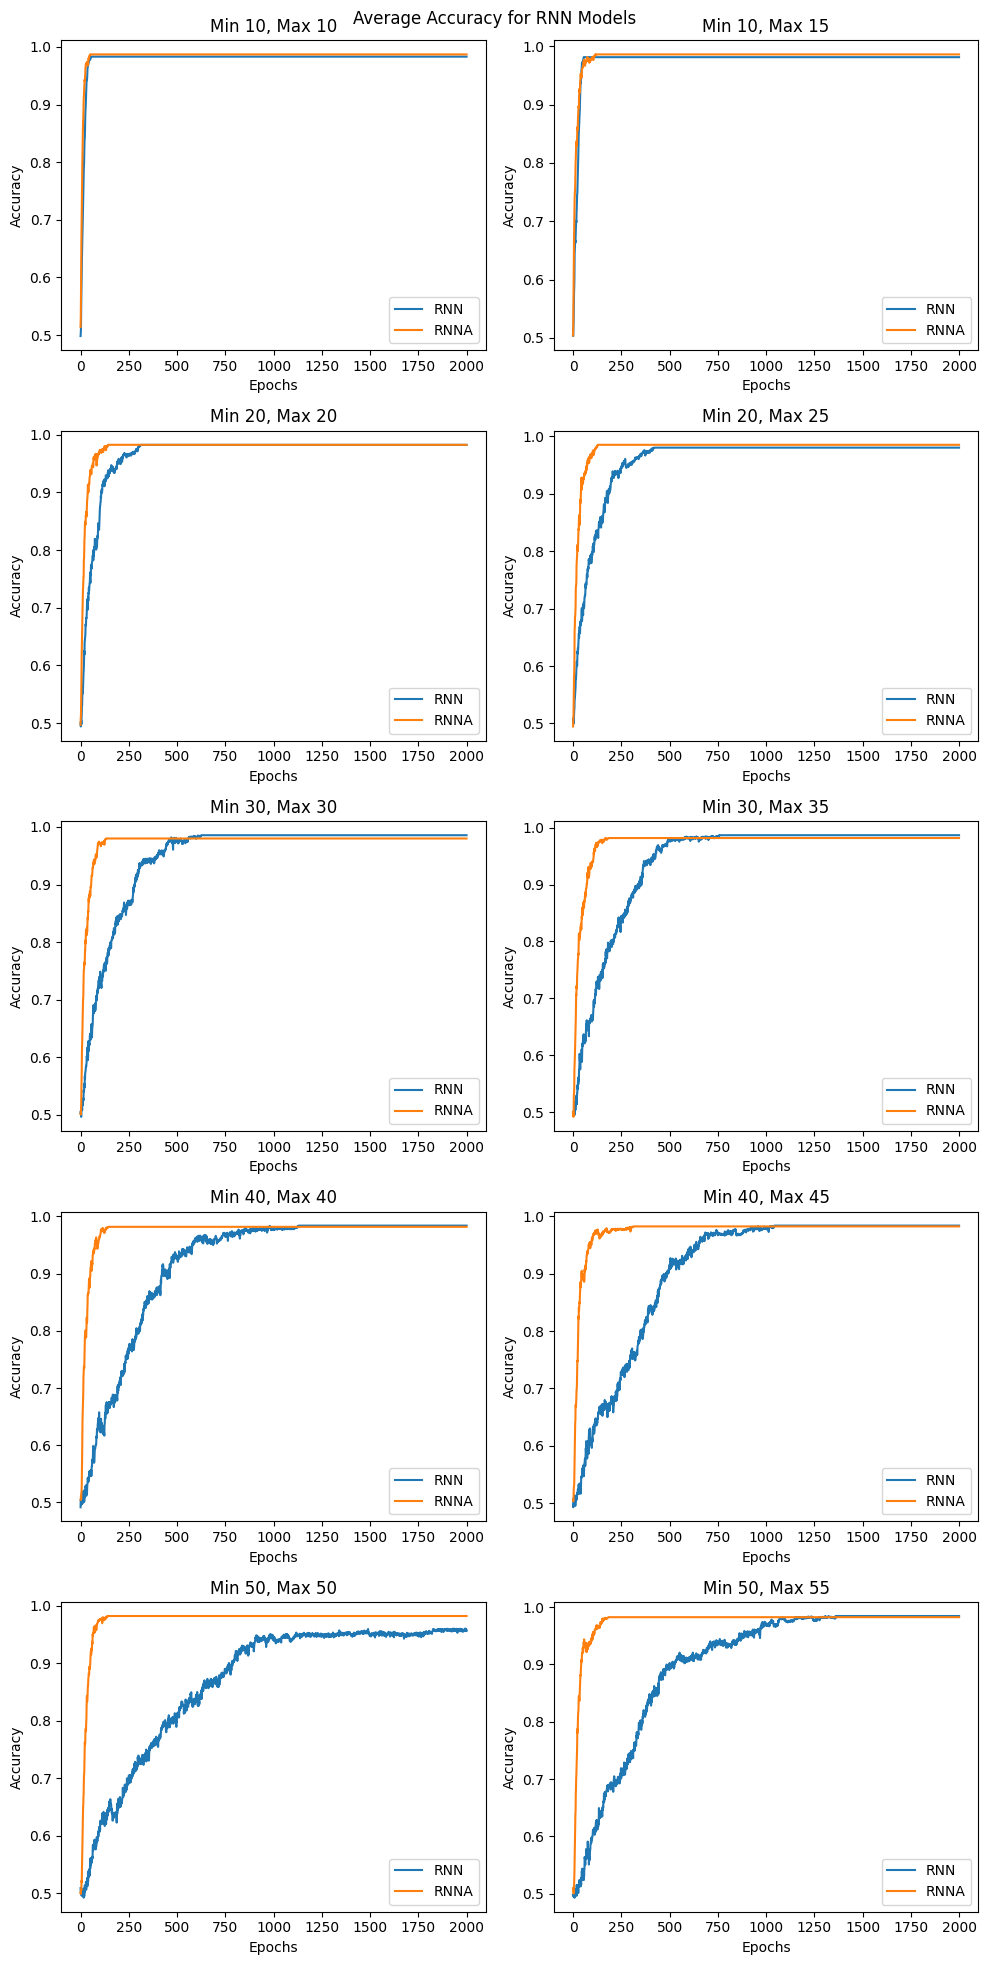

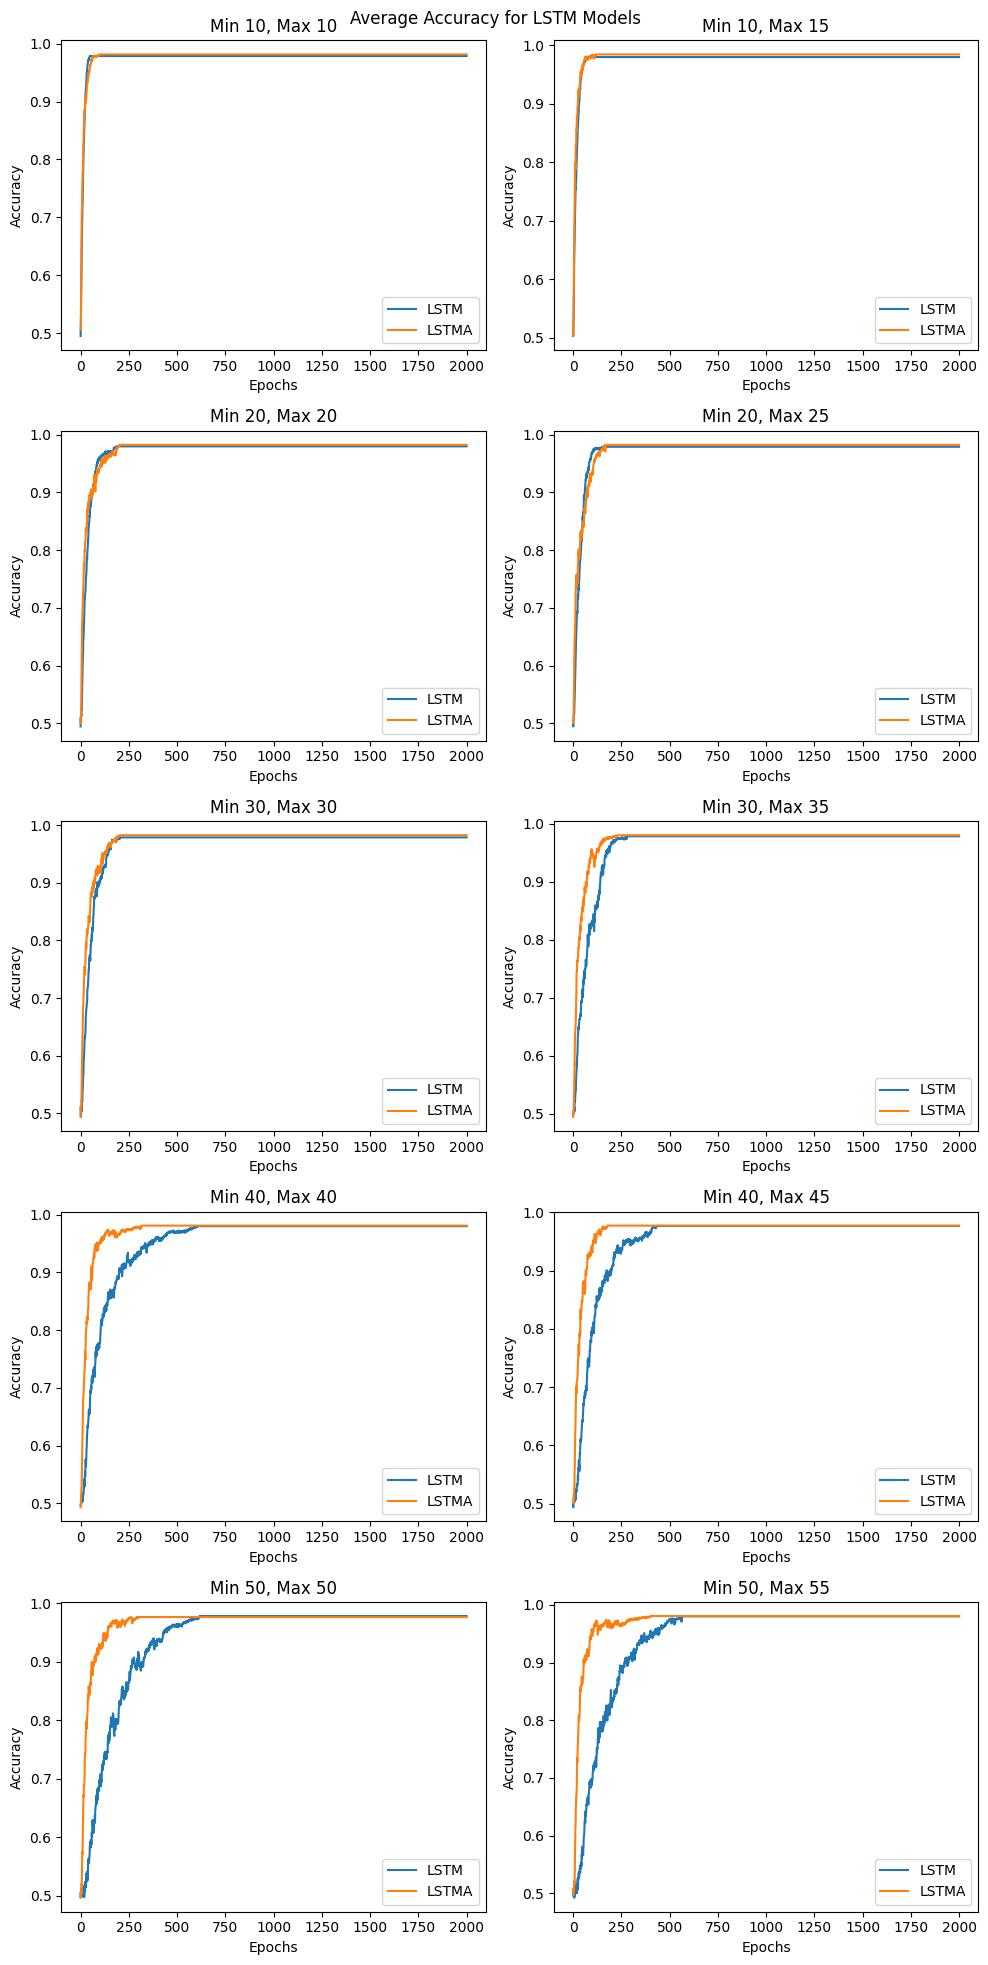

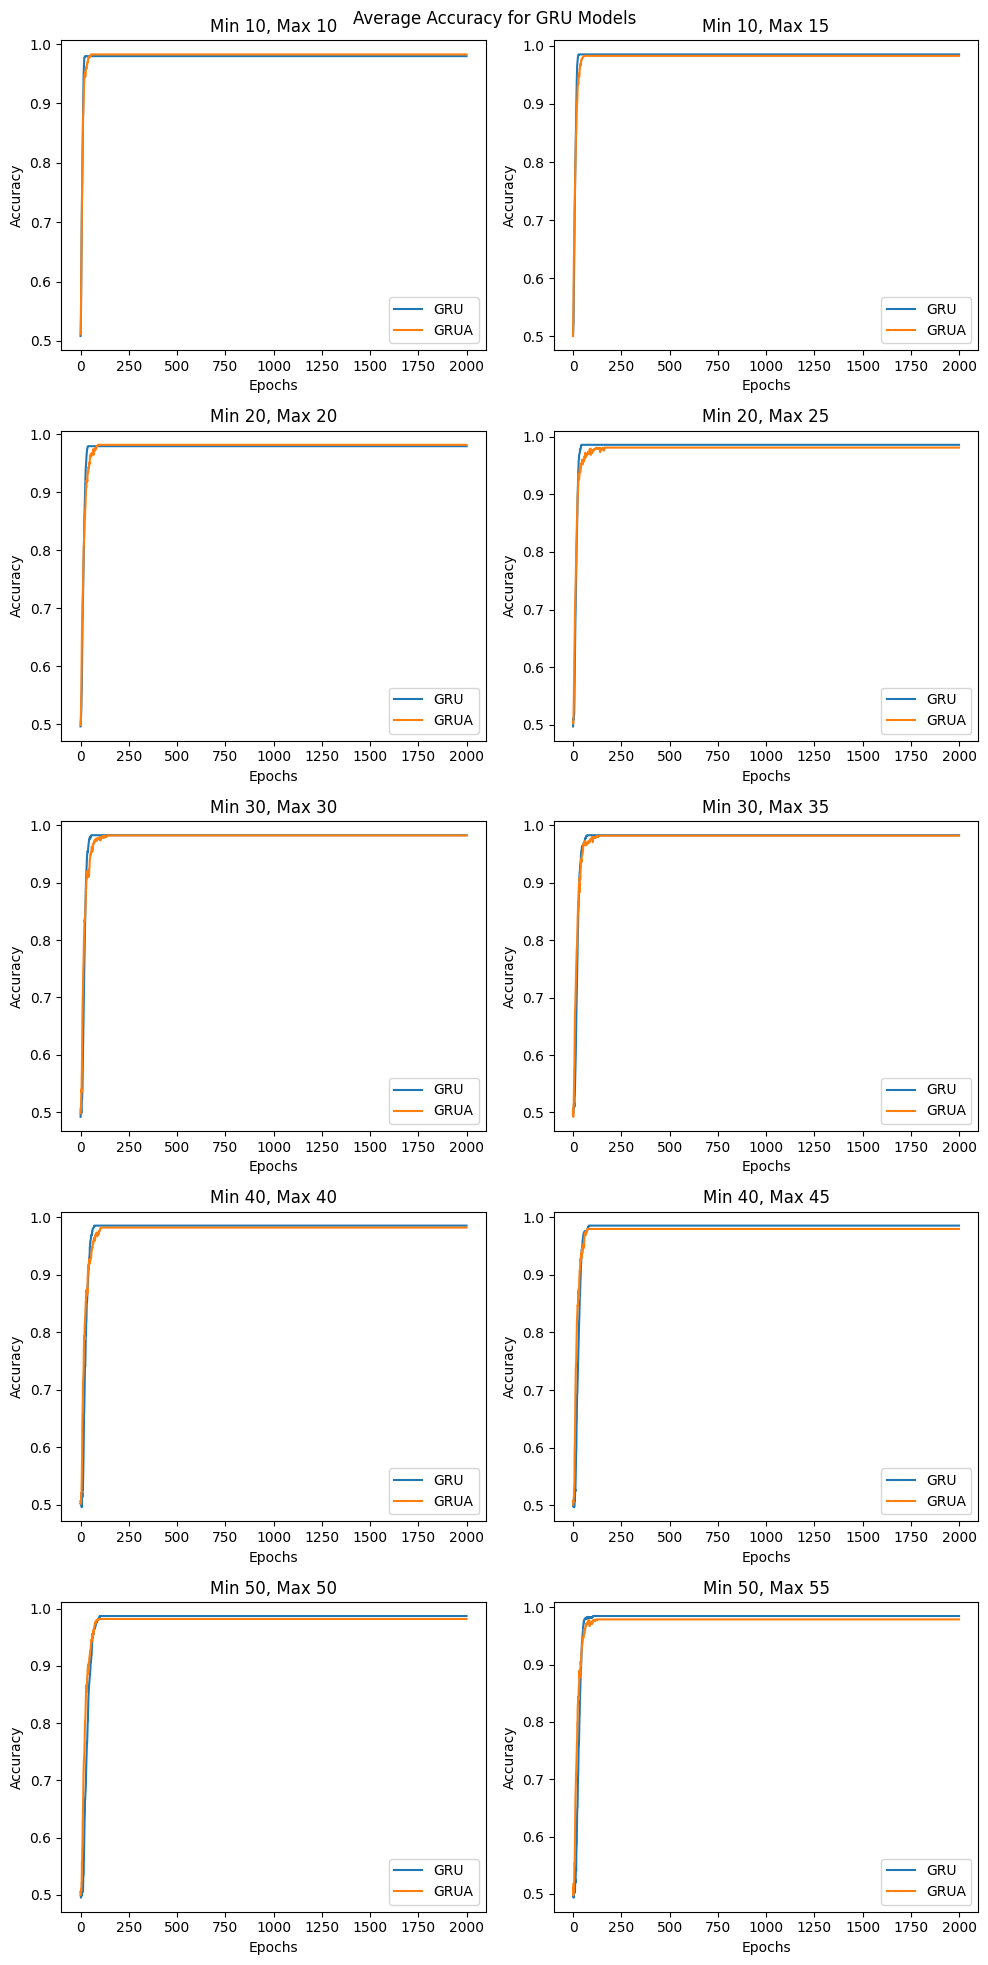

In [43]:
#model_groups = {
#    "RNN": ["RNN", "RNNA", "RNNE"],
#    "LSTM": ["LSTM", "LSTMA", "LSTME"],
#    "GRU": ["GRU", "GRUA", "GRUE"]
#}

model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Plotting for each model group
for group_name, kinds in model_groups.items():
    plt.figure(figsize=(10, 20))  # Create a single figure for the 2x5 grid

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        for kind in kinds:
            kind_avg_data = []

            for rep in range(num_reps):
                #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                    kind_avg_data.append(padded_data)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if kind_avg_data:
                # Calculate the average for this kind and length combination
                avg_data = np.mean(np.array(kind_avg_data), axis=0)
                ax.plot(avg_data, label=f"{kind}")

        ax.set_title(f"Min {min_len}, Max {max_len}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

    plt.suptitle(f"Average Accuracy for {group_name} Models")
    plt.tight_layout()
    plt.show()


In [ ]:
# Load the model
model = torch.load("./models/model_RNN_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode


# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = 1.0 * (target_tensor.detach() > 0.0)
        B = 1.0 * (output.detach() > 0.0)
        acc = (1.0 * (A.flatten() == B.flatten())).mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 100.00%
Average Test Loss: 0.2337


In [ ]:
# Load the model
model = torch.load("./models/model_NetRNNWithAttention_min_10_max_10.model")
model.eval()  # Set the model to evaluation mode

# Assuming generateTrainData is defined and returns sequences and targets
sequences, targets = generateTrainData(1000, [10,10])

# Convert sequences and targets to tensors and pad sequences
seq_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in sequences]
padded_seq_tensors = pad_sequence(seq_tensors, batch_first=True)
target_tensors = torch.tensor(targets, dtype=torch.float32)

# Define the loss function
criterion = nn.MSELoss()

# Evaluate the model on test data
with torch.no_grad():
    total_acc = 0.0
    total_loss = 0.0

    for seq_tensor, target_tensor in zip(padded_seq_tensors, target_tensors):
        # Add batch dimension
        seq_tensor = seq_tensor.unsqueeze(0)
        target_tensor = target_tensor.unsqueeze(0)

        output = model(seq_tensor)

        # Calculate the loss
        loss = criterion(output, target_tensor)
        total_loss += loss.item()

        # Calculate accuracy
        A = (target_tensor > 0.0).float()
        B = (output > 0.0).float()
        acc = (A.flatten() == B.flatten()).float().mean()
        total_acc += acc.item()
    # Calculate average accuracy and loss
    avg_acc = total_acc / len(padded_seq_tensors)
    avg_loss = total_loss / len(padded_seq_tensors)
    print(f"Average Test Accuracy: {avg_acc * 100:.2f}%")
    print(f"Average Test Loss: {avg_loss:.4f}")


Average Test Accuracy: 87.50%
Average Test Loss: 0.4793


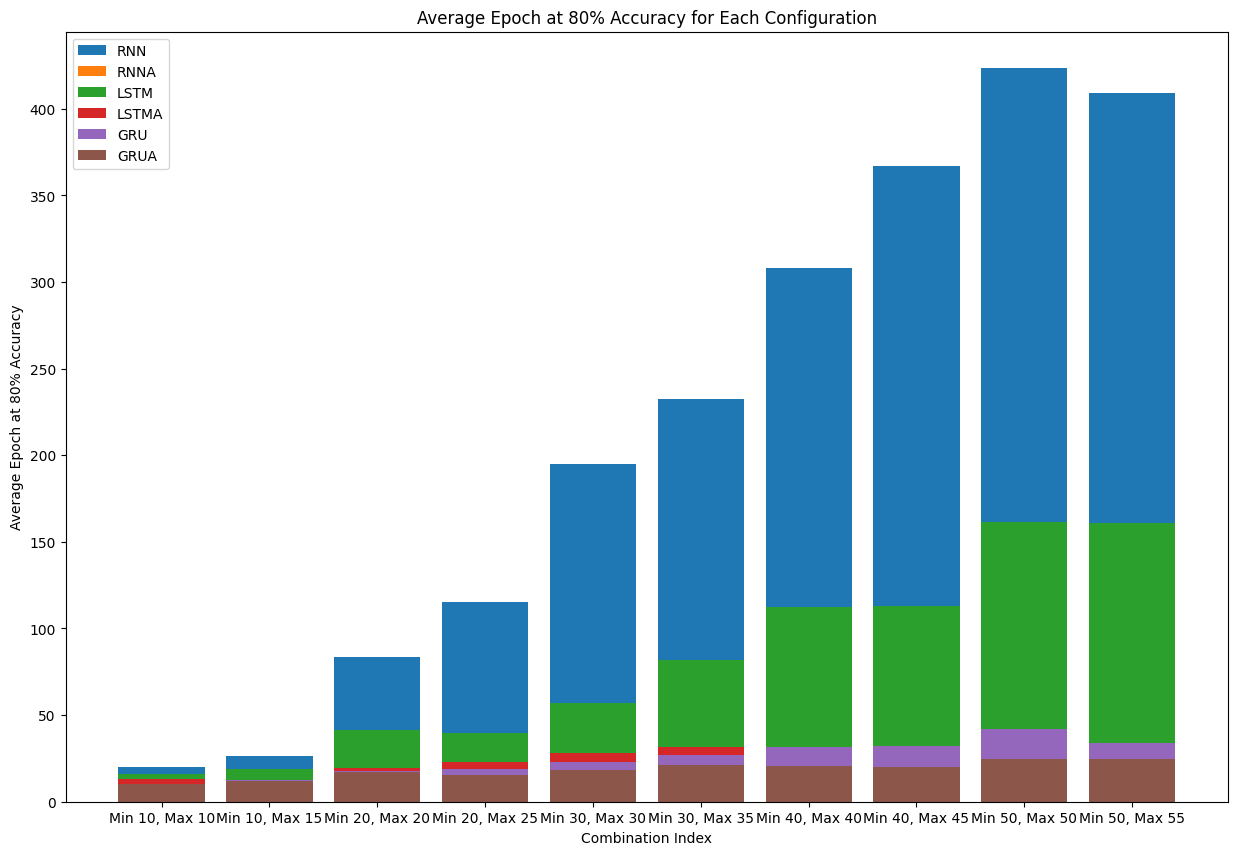

In [44]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

# Placeholder for the results
results = []
labels = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results.append((kind, min_len, max_len, avg_epoch))
            labels.append(f"Min {min_len}, Max {max_len}")


# Preparing data for bar plot
df = pd.DataFrame(results, columns=["Kind", "Min_Length", "Max_Length", "Avg_Epoch"])

# Plotting
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    subset = df[df['Kind'] == kind]
    x = range(len(subset))
    plt.bar(x, subset['Avg_Epoch'], tick_label=labels[len(x)*i:len(x)*(i+1)],label=f"{kind}")

plt.xlabel("Combination Index")
plt.ylabel("Average Epoch at 80% Accuracy")
plt.title("Average Epoch at 80% Accuracy for Each Configuration")
plt.legend()
plt.show()

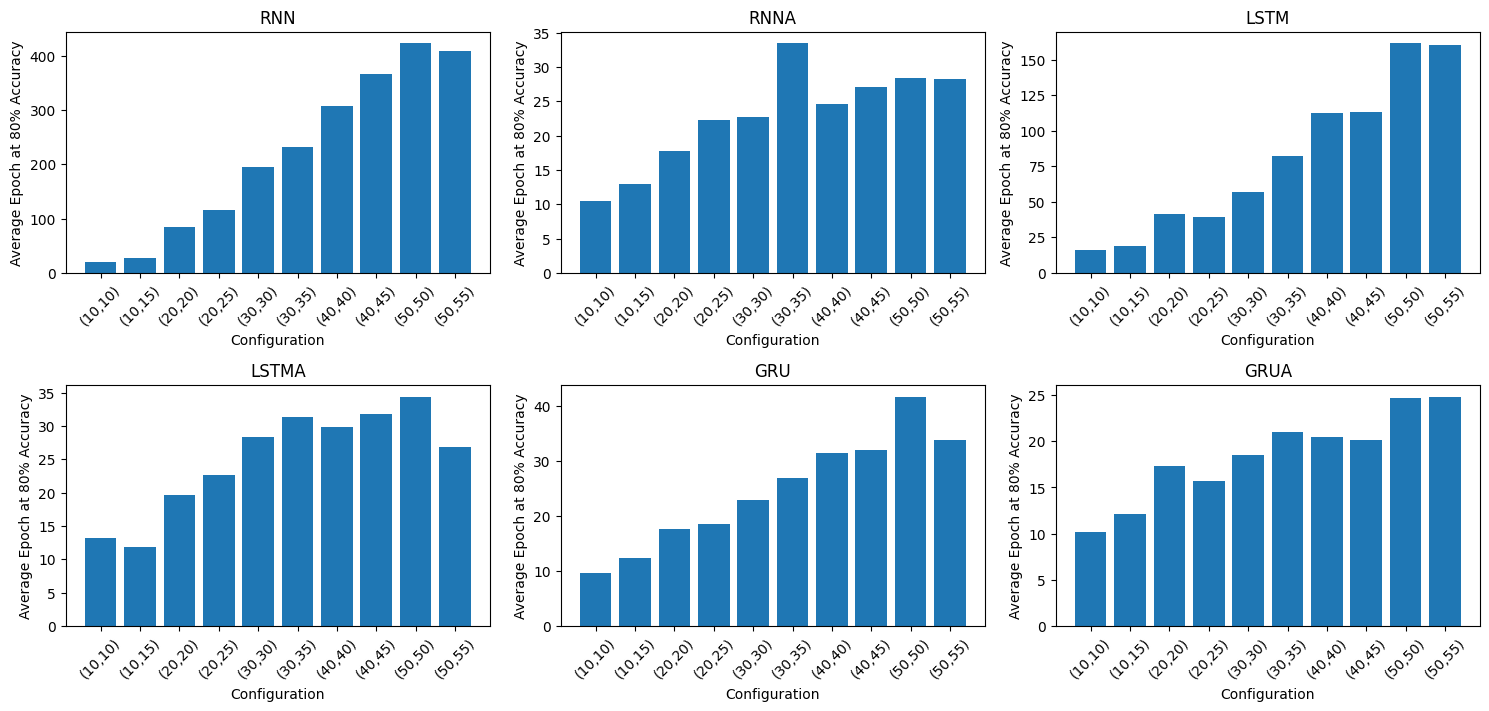

In [52]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
# Placeholder for the results
results = []
bar_labels = []

# Loop through each kind
for kind in kinds:
    kind_results = []
    kind_labels = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)
        
        kind_labels.append(f"({min_len},{max_len})")

    results.append(kind_results)
    bar_labels.append(kind_labels)

# Plotting
plt.figure(figsize=(15, 10))

# Create a subplot for each kind
for i, kind in enumerate(kinds):
    plt.subplot(3, 3, i + 1)  # Adjust subplot layout as needed
    plt.bar(range(len(min_lengths)), results[i], tick_label=bar_labels[i])
    plt.title(kind)
    plt.xlabel("Configuration")
    plt.ylabel("Average Epoch at 80% Accuracy")
    plt.xticks(rotation=45)  # Rotate labels for better readability

plt.tight_layout()
plt.show()

# Representation plots


In [114]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    figure()
    hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    print(f"fullSet: {fullSet}")
    nRes=copy.deepcopy(res)
    print(f"nRes before insert: {nRes}")
    nRes.insert(0,fullSet)
    print(f"nRes after insert: {nRes}")

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    #print(f"nodelist: {nodeList}")
    #print(f"H {H}")
    for i,node in enumerate(nodeList):
        #print(f"i {i}, node {node}")
        #print(f"H[0] {H[0]}")
        #print(f"H[i] {H[i]}")
        V[node]=H[0]-H[i]
        #print(f"H[0]-H[i] {H[0]-H[i]}")
        #print(f"V[node] {V[node]}")
    print(f"V {V}")

    #V=sqrt(V)
    #print(f"sum {V.sum()}")
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

s {0: [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 2, 4, 5, 7, 8, 9, 10, 11], [0, 1, 4, 5, 7, 8, 9, 10, 11], [0, 1, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 7, 10, 11], [0, 4, 5, 7, 10, 11], [4, 5, 7, 10, 11], [5, 7, 10, 11], [7, 10, 11], [10, 11], [11], []], 1: [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 9, 10, 11], [0, 3, 4, 5, 7, 9, 10, 11], [3, 4, 5, 7, 9, 10, 11], [4, 5, 7, 9, 10, 11], [4, 5, 7, 10, 11], [5, 7, 10, 11], [5, 7, 10], [7, 10], [10], []]}
H {0: [0.035890379227506486, 0.046324305421220124, 0.042290474857026084, 0.042290474857026084, 0.0180302495457223, 0.013127999588991912, 0.013127999588991912, 0.0, 0.0, 0.0, 0.0, 0.0], 1: [0.11032798996278492, 0.106534098822749, 0.10653409882274856, 0.06930068552572344, 0.04175181050408883, 0.014090509994501232, 0.014090509994501232, 4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16, 4.440892098500626e-16, 0.0]}
fullSet: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
nRes before inser

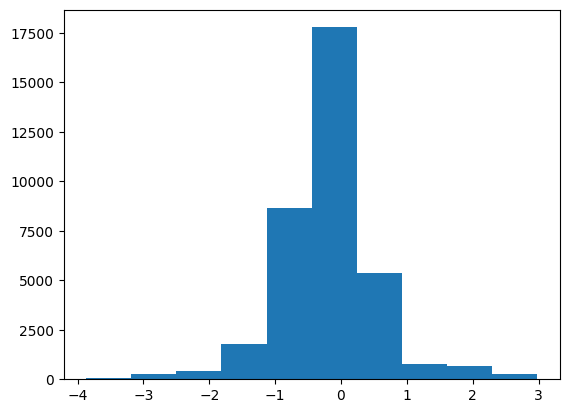

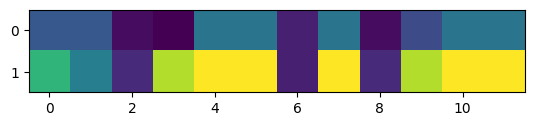

In [115]:

modelRNNWithAttention=torch.load("./data/model_LSTM_min_30_max_35_rep_4.model")
modelRNN=torch.load("./data/model_LSTMA_min_30_max_35_rep_4.model")
modelRNNWithAttentionExp =torch.load("./data/model_LSTME_min_30_max_35_rep_4.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
print(f"s {S}")
print(f"H {H}")
figure()
print(f"M {removalIntoMatrix(S,12,H)}")
imshow(removalIntoMatrix(S,12,H))
#S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
#figure()
#imshow(removalIntoMatrix(S,12,H))
#S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
#figure()
#imshow(removalIntoMatrix(S,12,H))

In [ ]:
# Load the model
model = torch.load("./Models/model_RNN_min_5_max_5.model")
model.eval()  # Set the model to evaluation mode


plt.figure(figsize=(15, 20))  # Adjust the size as needed

# Run the analysis
for i in range(1):
    s, t = generateTrainData(5, [5,5])  # Use your generateTrainData function
    # Visualize the results
    S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),numbers=[0,1,2],whichTS=i,dsLength=5)
    subplot(6,2,i+1)
    M=removalIntoMatrix(S,12,H)
    ax = plt.subplot(6, 2, i+1)  # Arrange in 5 rows and 2 columns
    im = ax.imshow(M)
    ax.set_title(f'Subplot {i} - model_RNN_min_10_max_10')
    plt.colorbar(im, ax=ax)  # Add a colorbar to each subplot
    print(f'Plot {i} - Min: {M.min()}, Max: {M.max()}')
    print(f'S - {i} {S}')
    print(f'H - {i} {H}') 
    print(f'M - {i} {M}')
plt.tight_layout()  # Adjust the spacing between plots
plt.show() 

In [ ]:
print(len(S))
print(len(S[0]))
print(H[0])
print(len(H[0]))

3
12
[0.5509775004326938, 0.5509775004326938, 0.5509775004326938, 0.40000000000000036, 0.40000000000000036, 0.40000000000000036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
12


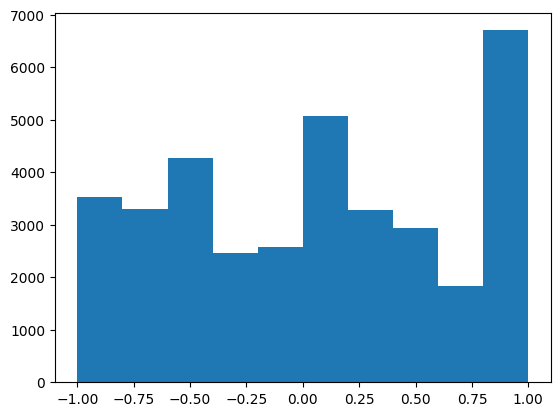

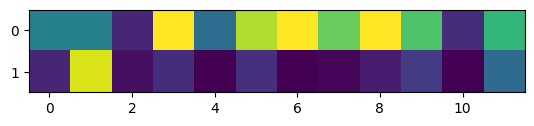

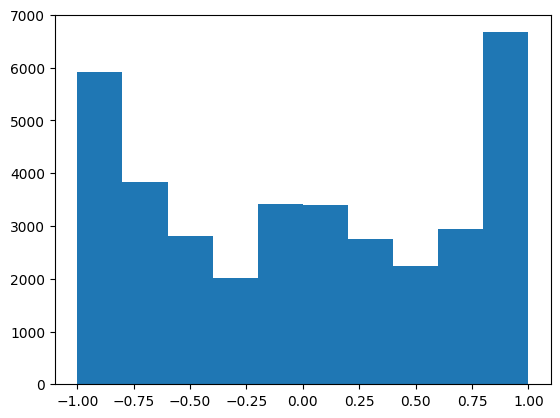

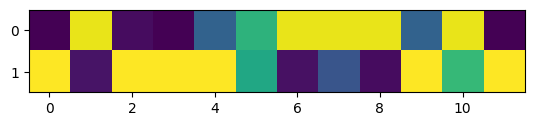

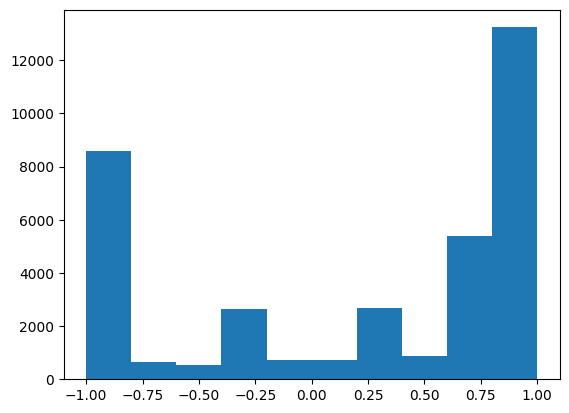

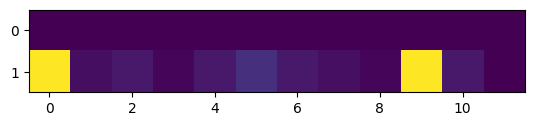

In [27]:

modelRNNWithAttention=torch.load("./data/model_RNN_min_30_max_35_rep_4.model")
modelRNN=torch.load("./data/model_RNNA_min_30_max_35_rep_4.model")
modelRNNWithAttentionExp =torch.load("./data/model_RNNE_min_30_max_35_rep_4.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))

fullSet: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
nRes before insert: [[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 9, 10, 11], [1, 4, 5, 9, 10, 11], [4, 5, 9, 10, 11], [5, 9, 10, 11], [5, 10, 11], [10, 11], [11], []]
nRes after insert: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 9, 10, 11], [1, 4, 5, 9, 10, 11], [4, 5, 9, 10, 11], [5, 9, 10, 11], [5, 10, 11], [10, 11], [11], []]
nodelist: [6, 2, 8, 3, 7, 0, 1, 4, 9, 5, 10, 11]
fullSet: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
nRes before insert: [[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 3, 4, 5, 6, 7, 9, 10, 11], [0, 1, 3, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 7, 9, 10, 11], [0, 1, 4, 5, 9, 10, 11], [0, 4, 5, 9, 10, 11], [4, 5, 9, 10, 11], [5, 9, 10, 11], [9, 10, 11], [10, 11], [11], []]
nRes after insert:

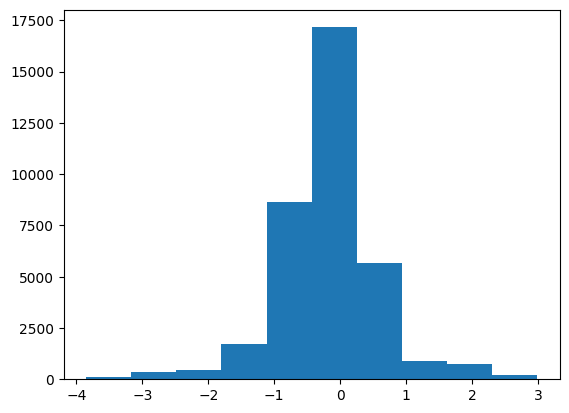

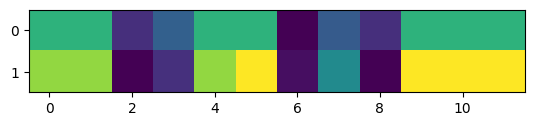

In [99]:

modelRNNWithAttention=torch.load("./data/model_LSTM_min_30_max_35_rep_4.model")
modelRNN=torch.load("./data/model_LSTMA_min_30_max_35_rep_4.model")
modelRNNWithAttentionExp =torch.load("./data/model_LSTME_min_30_max_35_rep_4.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))
#S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
#figure()
#imshow(removalIntoMatrix(S,12,H))
#S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
#figure()
#imshow(removalIntoMatrix(S,12,H))

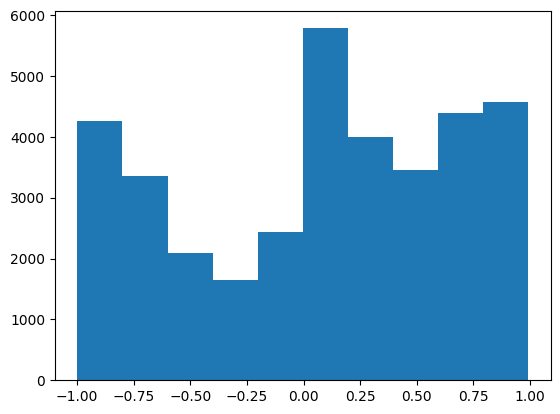

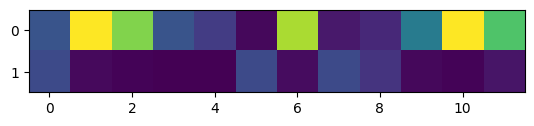

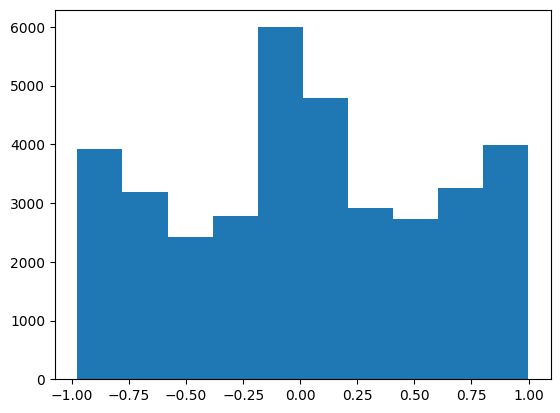

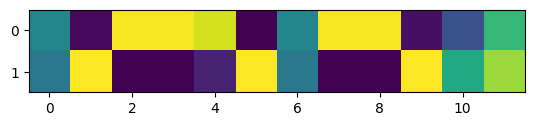

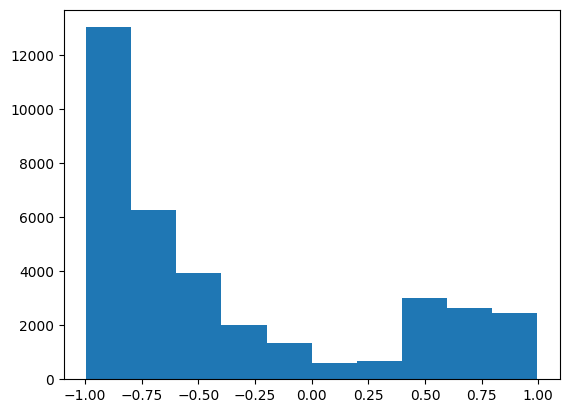

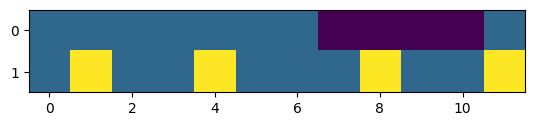

In [29]:

modelRNNWithAttention=torch.load("./data/model_GRU_min_30_max_35_rep_4.model")
modelRNN=torch.load("./data/model_GRUA_min_30_max_35_rep_4.model")
modelRNNWithAttentionExp =torch.load("./data/model_GRUE_min_30_max_35_rep_4.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))
S,H=shrinkingDecompositionInformation(modelRNNWithAttentionExp,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
imshow(removalIntoMatrix(S,12,H))

In [ ]:
# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [5]
max_lengths = [5]


# Future analysis

In [ ]:
for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
    for min_len, max_len in zip(min_lengths, max_lengths):
        for rep in range(1):
            model=torch.load(f'./Models/model_{kind}_min_{min_len}_max_{max_len}.model')
            for i in range(5):
                s,t=generateTrainData(100,[min_len,max_len])
                S,H=shrinkingDecompositionInformation(model,12,s,t.transpose(),numbers=[0,1,2],whichTS=i,dsLength=5)
                M=removalIntoMatrix(S,12,H)
                pickle.dump([S,H,M],open(f'./Models/SHM_{kind}_min_{min_len}_max_{max_len}.p',"wb"))
            print(kind,rep)

RNN 0
RNNA 0
RNNE 0
LSTM 0
LSTMA 0
LSTMEGRU 0
GRUA 0
GRUE 0


RNN <function cond at 0x000002ABEA0ACA40> 0.9999999999999999 1.232595164407831e-32
RNNA <function cond at 0x000002ABEA0ACA40> 1.0 0.0
RNNE <function cond at 0x000002ABEA0ACA40> 1.0 0.0
LSTM <function cond at 0x000002ABEA0ACA40> 1.0 0.0
LSTMA <function cond at 0x000002ABEA0ACA40> 0.9999999999999998 0.0
LSTMEGRU <function cond at 0x000002ABEA0ACA40> 0.9999999999999999 1.232595164407831e-32
GRUA <function cond at 0x000002ABEA0ACA40> 0.9999999999999998 0.0
GRUE <function cond at 0x000002ABEA0ACA40> 1.0 0.0


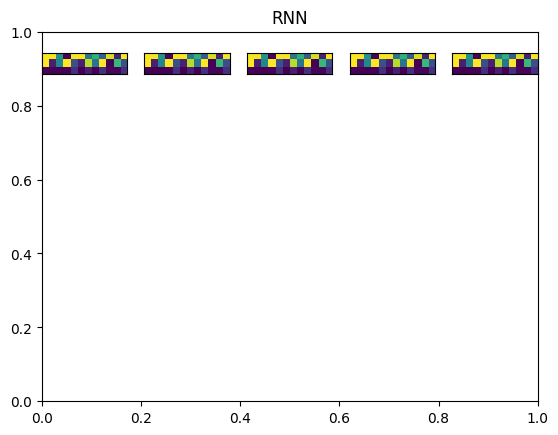

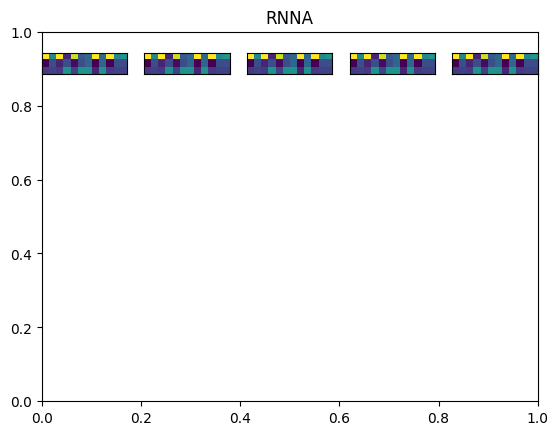

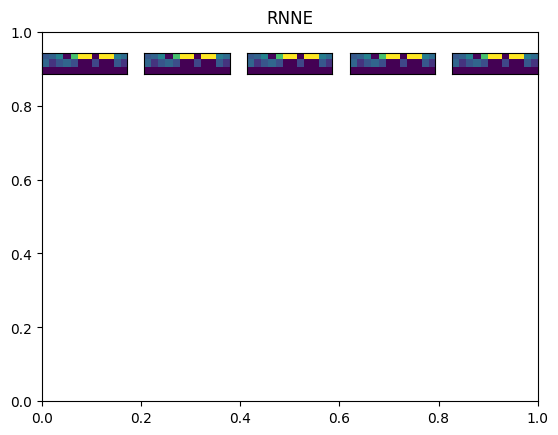

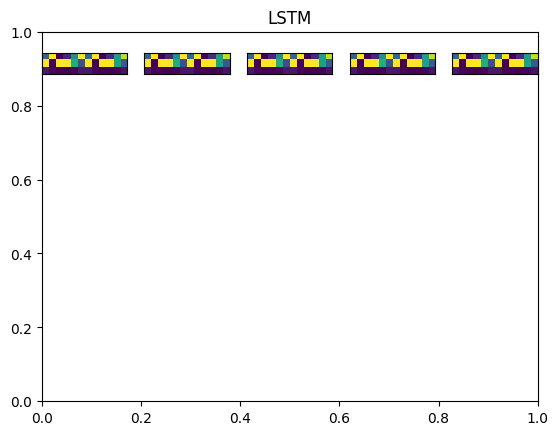

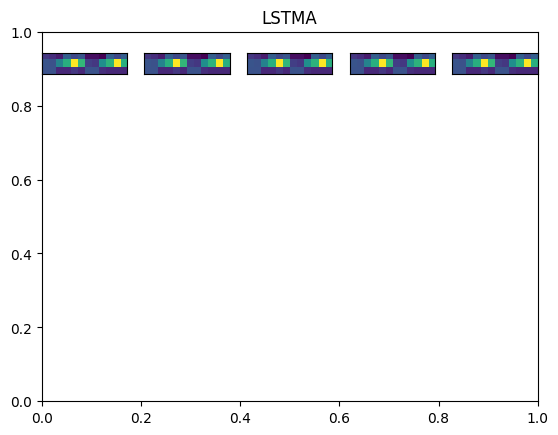

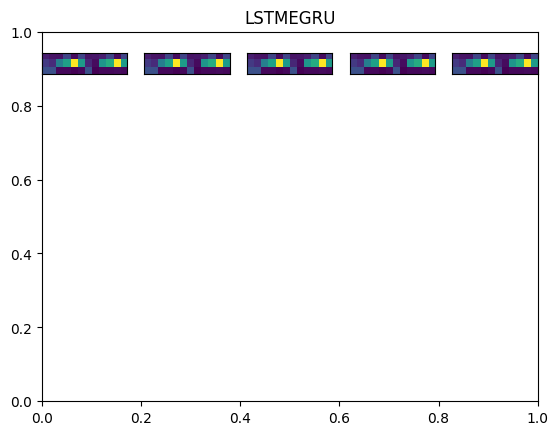

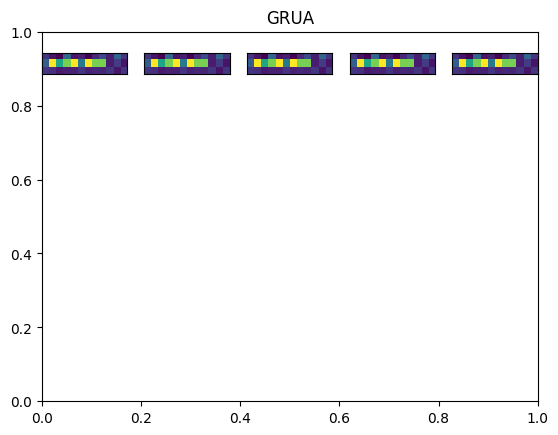

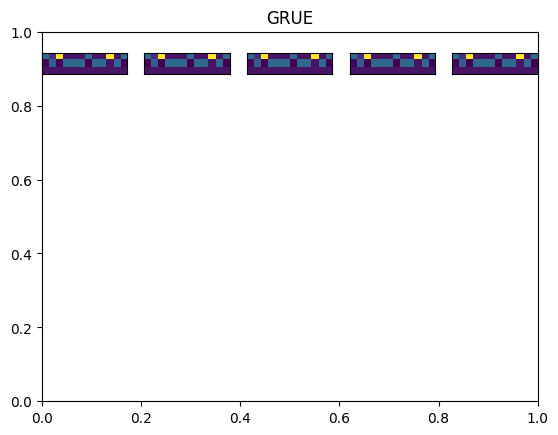

In [ ]:
collectorSHM=dict()
for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
    for min_len, max_len in zip(min_lengths, max_lengths):
        C=[]
        figure()
        title(kind)
        where=1
        for rep in range(1):
            Ms=[]
            for i in range(5):#[6,7,8,9,10]:
                S,H,M=pickle.load(open(f'./Models/SHM_{kind}_min_{min_len}_max_{max_len}.p',"rb"))
                collectorSHM[f'{k}_min_{min_len}_max_{max_len}_{rep}_{i}']=M
                Ms.append(M.flatten())
                if rep==0:
                    subplot(5,5,where)
                    where+=1
                    imshow(M)
                    xticks([])
                    yticks([])
            for i in range(5):
                for j in range(5):
                    if i>j:
                        cc=corrcoef(Ms[i],Ms[j])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
pickle.dump(collectorSHM,open("collectorSHMlong.p","wb"))

In [ ]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * numpy.array(data)
    n = len(a)
    m, se = numpy.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

RNN <function cond at 0x000002ABEA0ACA40> 0.9999999999999999 1.232595164407831e-32
RNNA <function cond at 0x000002ABEA0ACA40> 1.0 0.0
RNNE <function cond at 0x000002ABEA0ACA40> 1.0 0.0
LSTM <function cond at 0x000002ABEA0ACA40> 1.0 0.0
LSTMA <function cond at 0x000002ABEA0ACA40> 0.9999999999999998 0.0
LSTMEGRU <function cond at 0x000002ABEA0ACA40> 0.9999999999999999 1.232595164407831e-32
GRUA <function cond at 0x000002ABEA0ACA40> 0.9999999999999998 0.0
GRUE <function cond at 0x000002ABEA0ACA40> 1.0 0.0


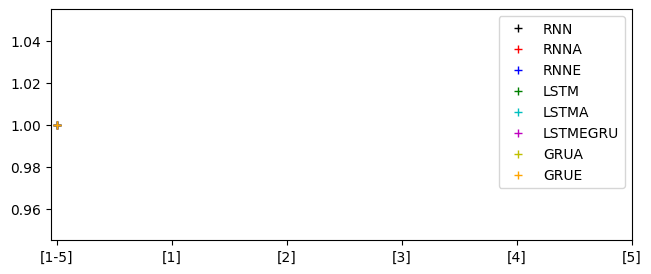

In [ ]:
figure(figsize=[7.5,3])
cols = [
    'k',  # black
    'r',  # red
    'b',  # blue
    'g',  # green
    'c',  # cyan
    'm',  # magenta
    'y',  # yellow
    'orange',  # orange
    'purple'   # purple
]

collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))
for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
    MC=[]
    MS=[]
    for min_len, max_len in zip(min_lengths, max_lengths):
        for rep in range(1):
            Ms=[]
            C=[]
            for i in range(5):#[6,7,8,9,10]:
                M=collectorSHM[f'{k}_min_{min_len}_max_{max_len}_{rep}_{i}']
                Ms.append(M.flatten())
                #if rep==0:
                #    subplot(5,5,where)
                #    where+=1
                #    imshow(M)
                #    xticks([])
                #    yticks([])
            for i in range(5):#[6,7,8,9,10]:
                for j in range(5):#[6,7,8,9,10]:
                    if i>j:
                        cc=corrcoef(Ms[i],Ms[j])[0][1]
                        C.append(cc)
        print(kind,cond,mean(C),var(C))
        MC.append(mean(C))
        MS.append(mean_confidence_interval(C))
    plot(range(1),MC,'+',color=cols[k],label=kind)
    plot(range(1),MC,':',linewidth=0.2,color=cols[k])
    xticks(range(6),['[1-5]','[1]','[2]','[3]','[4]','[5]'])
legend()

RNN [1, 2, 3, 4, 5] 1.0
RNNA [1, 2, 3, 4, 5] 1.0
RNNE [1, 2, 3, 4, 5] 1.0
LSTM [1, 2, 3, 4, 5] 1.0
LSTMA [1, 2, 3, 4, 5] 1.0
LSTMEGRU [1, 2, 3, 4, 5] 1.0
GRUA [1, 2, 3, 4, 5] 1.0
GRUE [1, 2, 3, 4, 5] 1.0


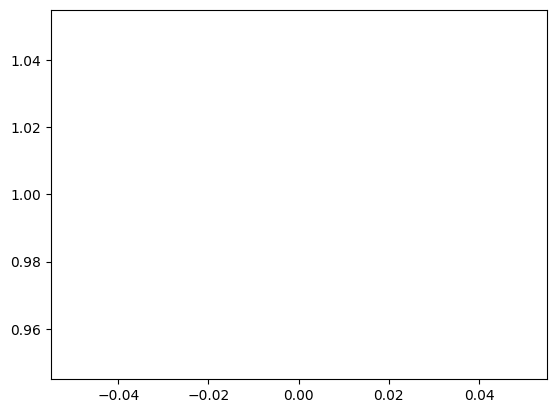

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))
for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
    Rs=[]
    RsS=[]
    for min_len, max_len in zip(min_lengths, max_lengths):
        R=[]
        for rep in range(1):
            Ns=[]
            for i in range(5):#[6,7,8,9,10]:
                M=collectorSHM[f'{k}_min_{min_len}_max_{max_len}_{rep}_{i}']
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                Ns.append(numpy.array(N))
            same=0
            diff=0
            for r in range(3):
                for n in range(4):
                    for i in range(12):
                        for j in range(12):
                            if i<j:
                                a= Ns[n][r][i]  == Ns[n][r][j]
                                b= Ns[n+1][r][i]== Ns[n+1][r][j]
                                if a==b:
                                    same+=1
                                else:
                                    diff+=1
            ratio=same/(same+diff)
            R.append(ratio)
        print(kind,td,mean(R))
        Rs.append(mean(R))
    plot(Rs)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
collectorSHM=pickle.load(open("collectorSHMlong.p","rb"))

rowDist=dict()
colDist=dict()
for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
    for min_len, max_len in zip(min_lengths, max_lengths):
        row=[]
        col=[]
        for rep in range(1):
            for i in range(5):#[6,7,8,9,10]:
                M=collectorSHM[f'{k}_min_{min_len}_max_{max_len}_{rep}_{i}']
                N=[]
                for j in range(3):
                    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(M[j].reshape((-1,1)))
                    N.append(kmeans.labels_)
                #subplot(1,5,i-10)
                #imshow(N)
                N=numpy.array(N)
                row.append(N.sum(0))
                col.append(N.sum(1))
        row=numpy.array(row)
        col=numpy.array(col)
        H0,H1=histogram(row.flatten(),[0,1,2,3,4])
        rowDist[f'{kind} {min_len} {max_len}']=H0/H0.sum()
        H0,H1=histogram(col.flatten(),[0,1,2,3,4,5,6,7,8,9,10,11,12,13])
        colDist[f'{kind} {min_len} {max_len}']=H0/H0.sum()
        print(kind,td,"row:",row.flatten().mean(),"col",col.flatten().mean())

RNN [1, 2, 3, 4, 5] row: 1.75 col 7.0
RNNA [1, 2, 3, 4, 5] row: 1.5 col 6.0
RNNE [1, 2, 3, 4, 5] row: 2.0833333333333335 col 8.333333333333334
LSTM [1, 2, 3, 4, 5] row: 1.3333333333333333 col 5.333333333333333
LSTMA [1, 2, 3, 4, 5] row: 1.8333333333333333 col 7.333333333333333
LSTMEGRU [1, 2, 3, 4, 5] row: 1.75 col 7.0
GRUA [1, 2, 3, 4, 5] row: 1.25 col 5.0
GRUE [1, 2, 3, 4, 5] row: 1.4166666666666667 col 5.666666666666667


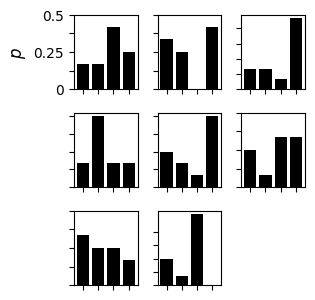

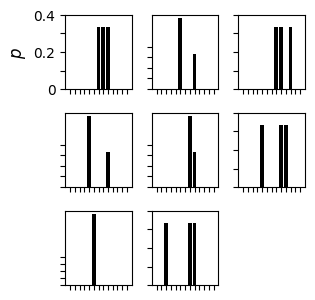

In [ ]:
figure(figsize=[3.25,6])
where=1
for min_len, max_len in zip(min_lengths, max_lengths):    
    for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
        subplot(6,3,where)
        where+=1
        H=rowDist[f'{kind} {min_len} {max_len}']
        bar([0,1,2,3],H,color='k')
        if cond==0:
            title(kind,fontsize=12)
        if k==0:
            yticks([0,0.125,0.25,0.375,0.5],["0","","0.25","","0.5"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.125,0.25,0.375,0.5],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3],["","","",""],fontsize=10)
tight_layout()

figure(figsize=[3.25,6])
where=1
for min_len, max_len in zip(min_lengths, max_lengths):    
    for k,kind in enumerate(["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME" "GRU", "GRUA","GRUE"]):
        subplot(6,3,where)
        where+=1
        if cond==0:
            title(kind,fontsize=12)
        H=colDist[f'{kind} {min_len} {max_len}']
        bar([0,1,2,3,4,5,6,7,8,9,10,11,12],H,color='k')
        if k==0:
            yticks([0,0.1,0.2,0.3,0.4],["0","","0.2","","0.4"],fontsize=10)
            ylabel(r"$p$",fontsize=12)
        else:
            yticks([0,0.1,0.2,0.3,0.4],["","","","",""],fontsize=10)
        if cond==5:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[0,"","","3","","",6,"","","9","","",12],fontsize=10)
            xlabel("concepts",fontsize=12)
        else:
            xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],[""]*13,fontsize=10)
            
tight_layout()